# Bike Sharing Demand Prediction
In this project, we understand the variables that affect the demand of bikes on a bike sharing platform. We also create a Linear Regression model to predict the demand for bikes.

We are trying to determine the most significant variables that affect the demand for shared bikes. The data has been provided by US bike sharing provider BoomBikes. BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic.

This project aims to determine the factors which can help the company take corrective measures to increase the demand and boost revenue. We are trying to model the demand for shared bikes with the available independent variables. It will be used by the Boombike management to understand how exactly the demands vary with different features. They can accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations. Further, the model will be a good way for management to understand the demand dynamics of a new market.

In [1016]:
# import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.stattools import durbin_watson  # for independent error assumption validation

In [1017]:
# read data
bikedata = pd.read_csv('day.csv')
bikedata.head()

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        6           0   
1        2  02-01-2018       1   0     1        0        0           0   
2        3  03-01-2018       1   0     1        0        1           1   
3        4  04-01-2018       1   0     1        0        2           1   
4        5  05-01-2018       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600

In [1018]:
# create a mapper dictionary for categorical variables
season_name_mapper = {1:'spring', 2:'summer', 3:'fall', 4:'winter'}
year_mapper = {0: '2018', 1:'2019'}
holiday_mapper = {0:'No Holiday', 1:'Holiday'}
workingday_mapper = {0:'Not Working', 1:'Working Day'}
weathersit_mapper = {1: 'Clear, Few clouds, Partly cloudy, Partly cloudy', 
                     2:'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist', 
                     3:'Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds', 
                     4:'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'}

## data cleaning

In [1019]:
bikedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


### no missing values

## convert dteday column into a datetime format

In [1020]:
bikedata.dteday = pd.to_datetime(bikedata.dteday, format='%d-%m-%Y')

In [1021]:
bikedata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     730 non-null    int64         
 1   dteday      730 non-null    datetime64[ns]
 2   season      730 non-null    int64         
 3   yr          730 non-null    int64         
 4   mnth        730 non-null    int64         
 5   holiday     730 non-null    int64         
 6   weekday     730 non-null    int64         
 7   workingday  730 non-null    int64         
 8   weathersit  730 non-null    int64         
 9   temp        730 non-null    float64       
 10  atemp       730 non-null    float64       
 11  hum         730 non-null    float64       
 12  windspeed   730 non-null    float64       
 13  casual      730 non-null    int64         
 14  registered  730 non-null    int64         
 15  cnt         730 non-null    int64         
dtypes: datetime64[ns](1), floa

#### `casual` and `registered` variables need to be dropped as cnt is just a sum of those two and thus those two are also like an output variable rather than independent input variables
#### we should also drop `instant` as this variable is not of any business relevance and its characteristics can be read from the date and year

In [1022]:
bikedata.drop(['instant', 'casual', 'registered'], axis=1, inplace=True)

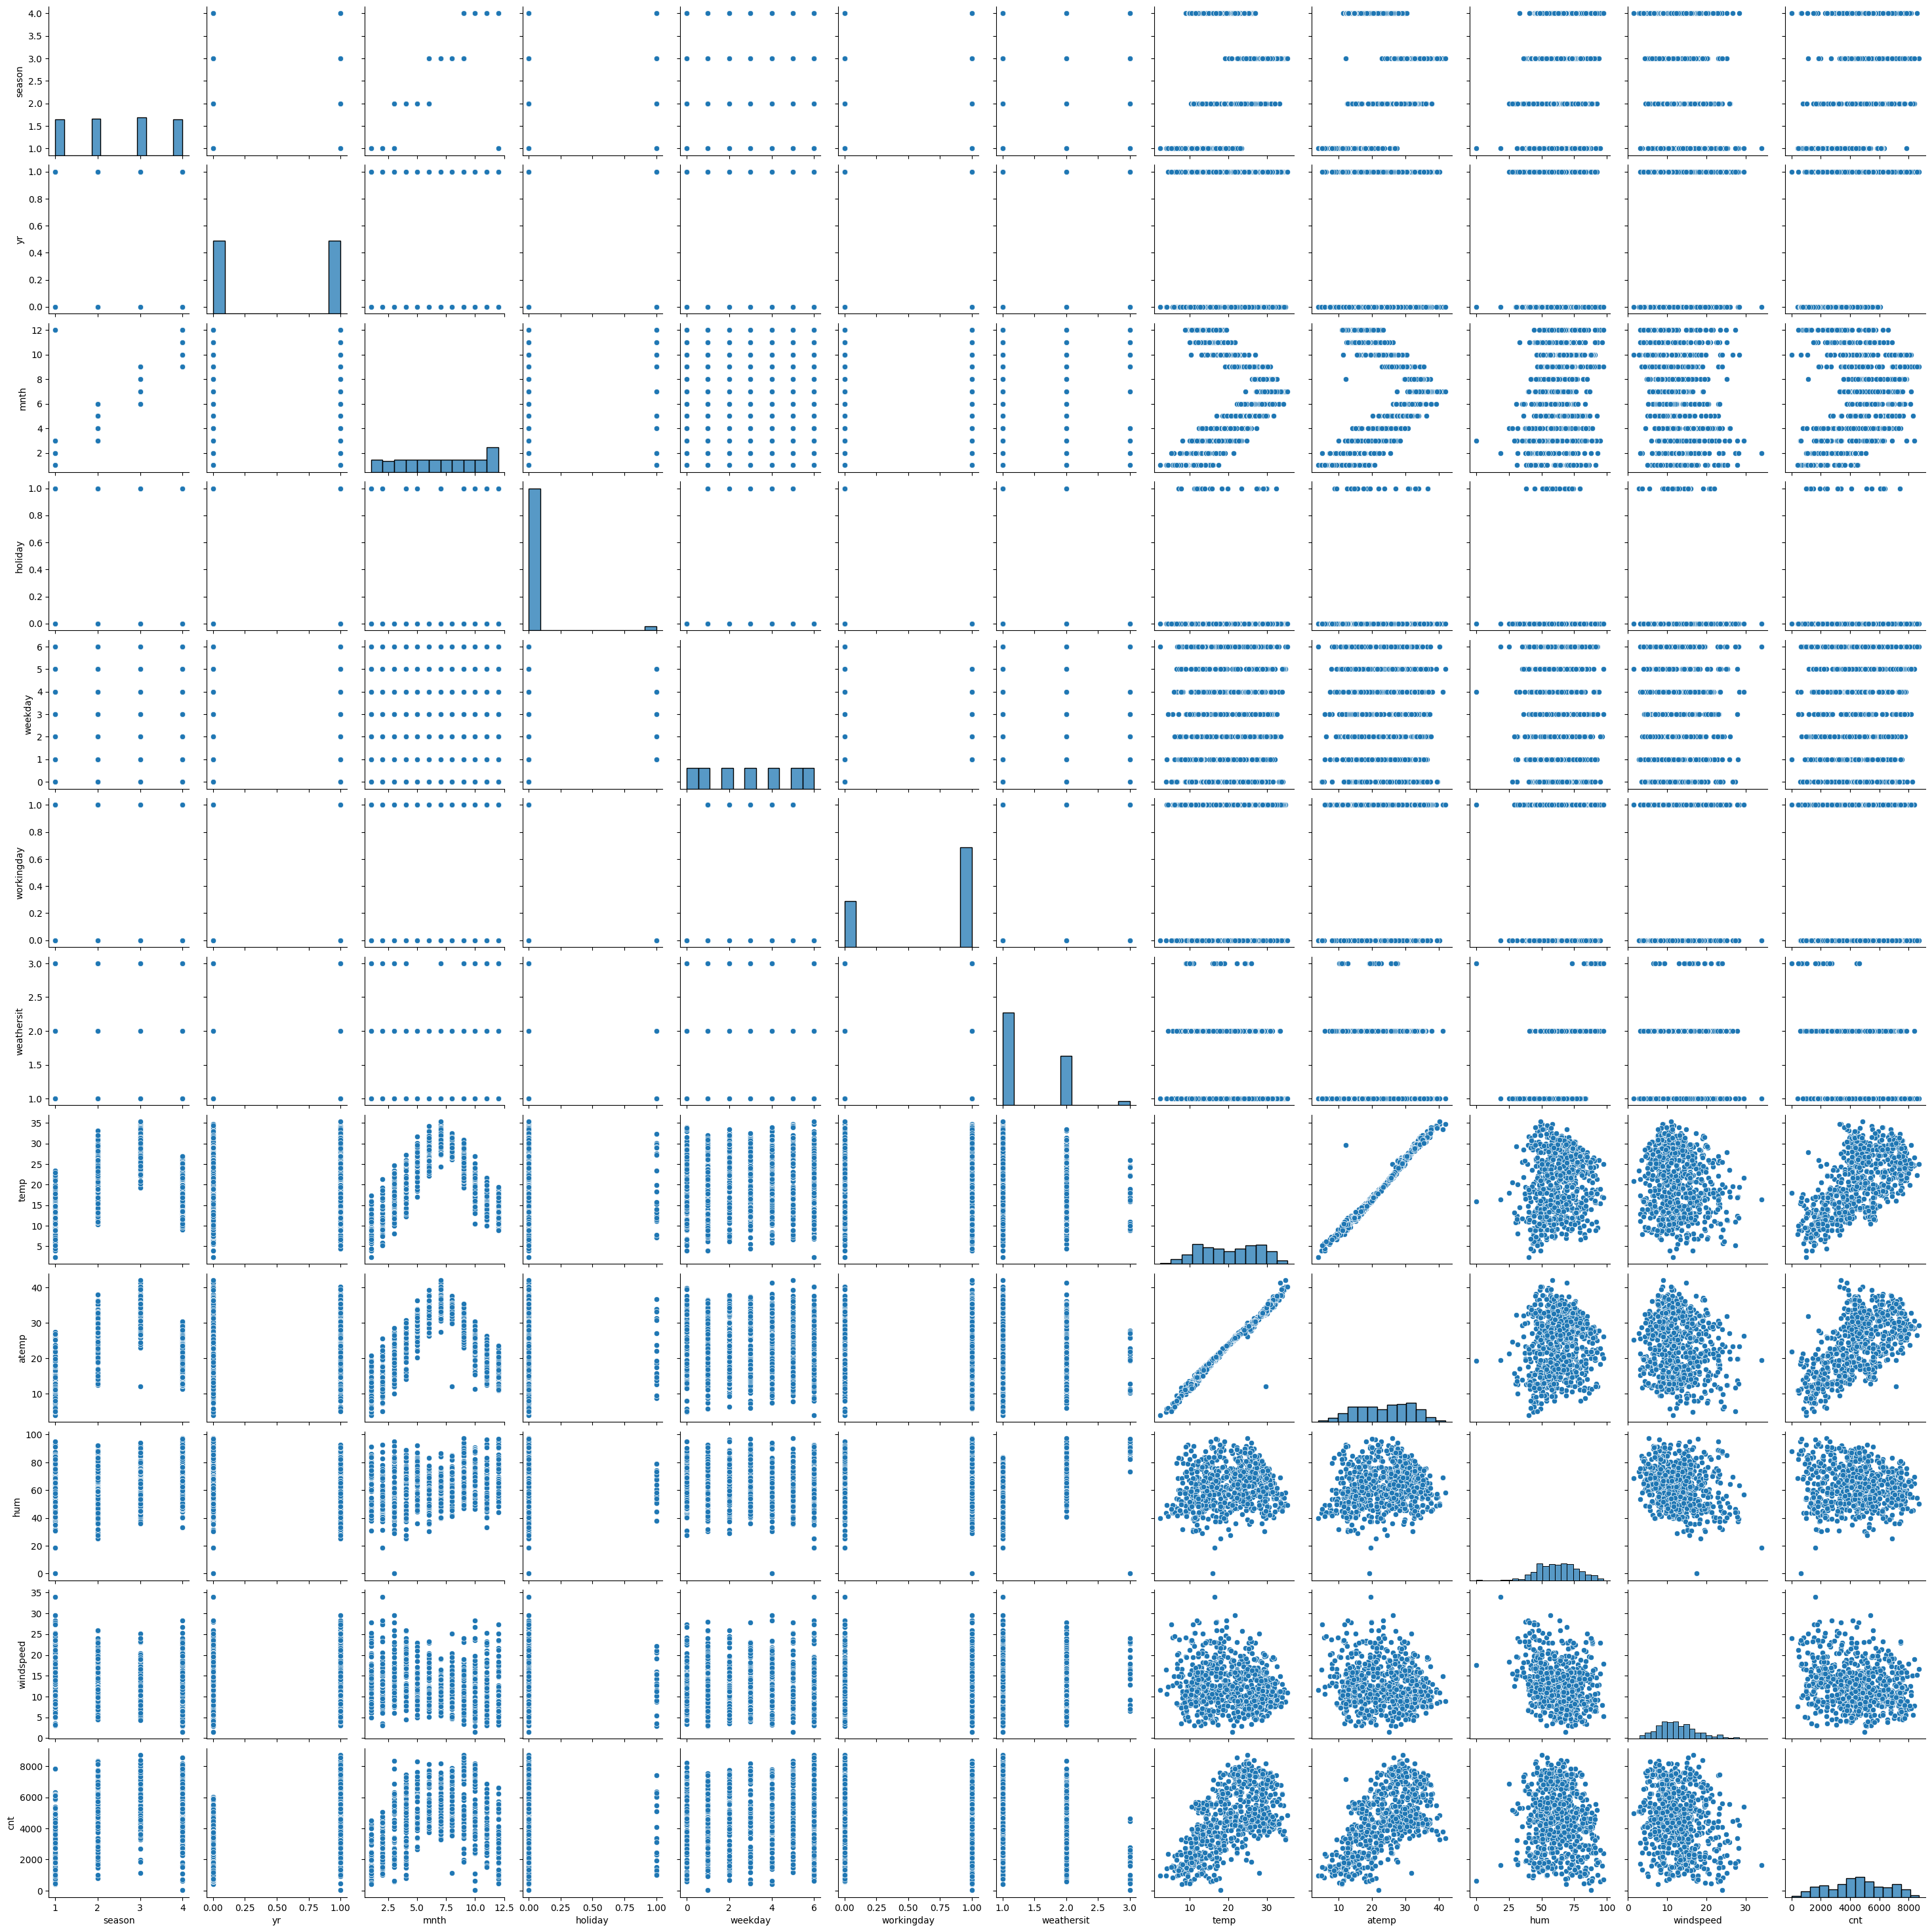

In [1023]:
sns.pairplot(bikedata)
plt.show()

In [1024]:
bikedata[['temp', 'atemp', 'hum', 'windspeed', 'cnt']].corr()

temp     atemp       hum  windspeed       cnt
temp       1.000000  0.991696  0.128565  -0.158186  0.627044
atemp      0.991696  1.000000  0.141512  -0.183876  0.630685
hum        0.128565  0.141512  1.000000  -0.248506 -0.098543
windspeed -0.158186 -0.183876 -0.248506   1.000000 -0.235132
cnt        0.627044  0.630685 -0.098543  -0.235132  1.000000

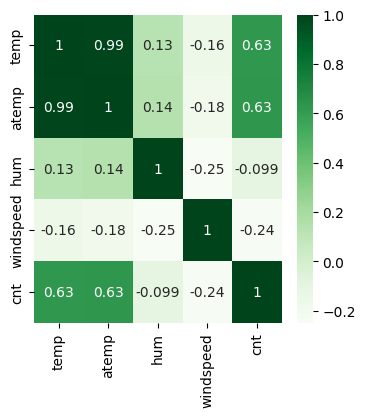

In [1025]:
# create a correlation plot of all numerical variables
plt.figure(figsize=(4,4))
sns.heatmap(bikedata[['temp', 'atemp', 'hum', 'windspeed', 'cnt']].corr(), cmap='Greens', annot=True)
plt.show()

#### the parameter atemp is a derived parameter from temp, humidity and windspeed and is highly correlated with the `temp` parameter and thus should be dropped. Here in linear regression we need to use independent variables anyway. But we will not drop it here as the VIF and p combined together should yield that same result.

In [1026]:
# bikedata.drop('atemp', axis=1, inplace=True)

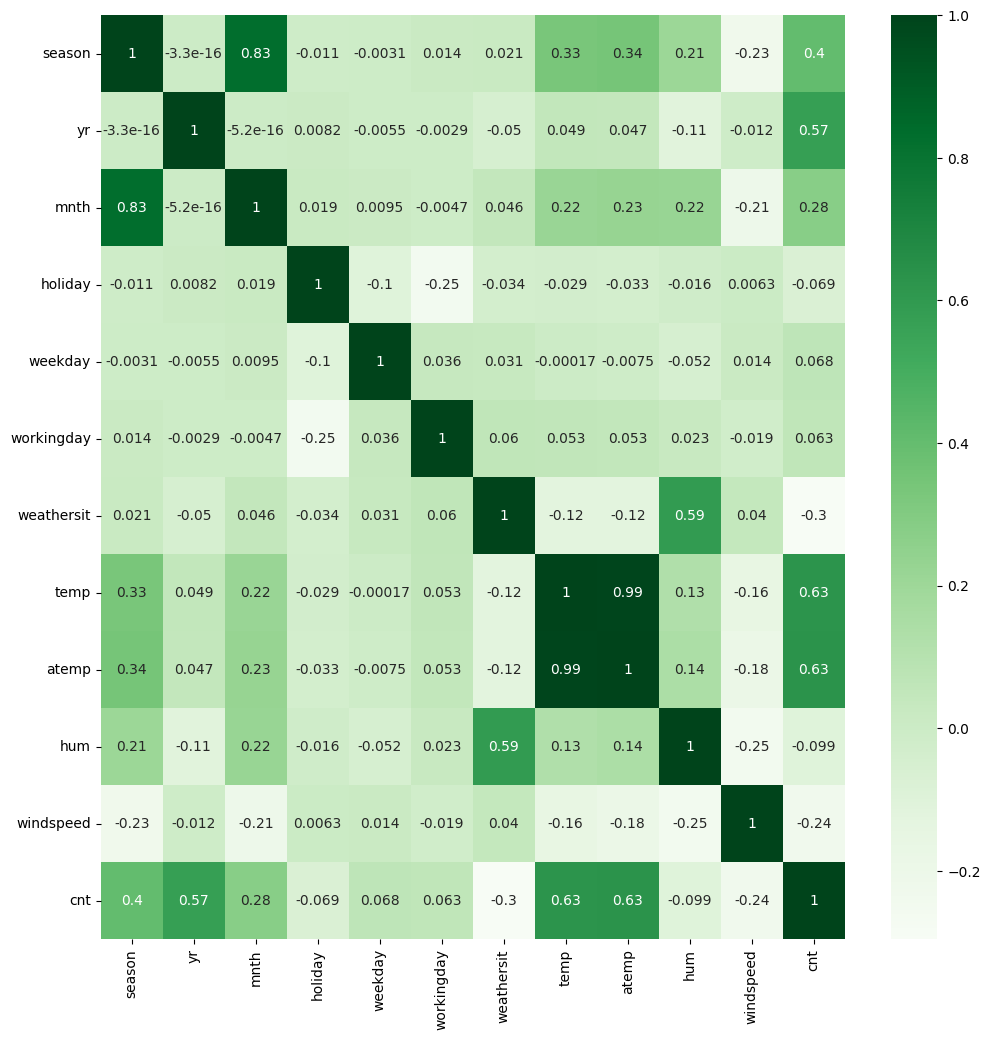

In [1027]:
plt.figure(figsize=(12,12))
sns.heatmap(bikedata.corr(), cmap='Greens', annot=True)
plt.show()

# outlier detection and removal

In [1028]:
# remove the outliers
def remove_outliers(col_name):
    global bikedata
    col = bikedata[col_name]
    q1 = np.quantile(col, 0.25)
    q3 = np.quantile(col, 0.75)
    lower_lim = q1 - 1.5*(q3 - q1)
    upper_lim = q3 + 1.5*(q3 - q1)
    bikedata = bikedata[(bikedata[col_name]>lower_lim) & (bikedata[col_name]<upper_lim)]

In [1029]:
bikedata.head()

dteday  season  yr  mnth  holiday  weekday  workingday  weathersit  \
0 2018-01-01       1   0     1        0        6           0           2   
1 2018-01-02       1   0     1        0        0           0           2   
2 2018-01-03       1   0     1        0        1           1           1   
3 2018-01-04       1   0     1        0        2           1           1   
4 2018-01-05       1   0     1        0        3           1           1   

        temp     atemp      hum  windspeed   cnt  
0  14.110847  18.18125  80.5833  10.749882   985  
1  14.902598  17.68695  69.6087  16.652113   801  
2   8.050924   9.47025  43.7273  16.636703  1349  
3   8.200000  10.60610  59.0435  10.739832  1562  
4   9.305237  11.46350  43.6957  12.522300  1600

In [1030]:
bikedata.season.value_counts()

3    188
2    184
1    180
4    178
Name: season, dtype: int64

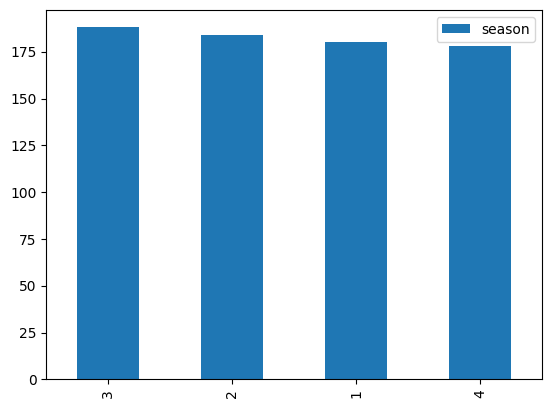

In [1031]:
bikedata.season.value_counts().plot.bar()
plt.legend()
plt.show()

In [1032]:
bikedata.yr.value_counts()

0    365
1    365
Name: yr, dtype: int64

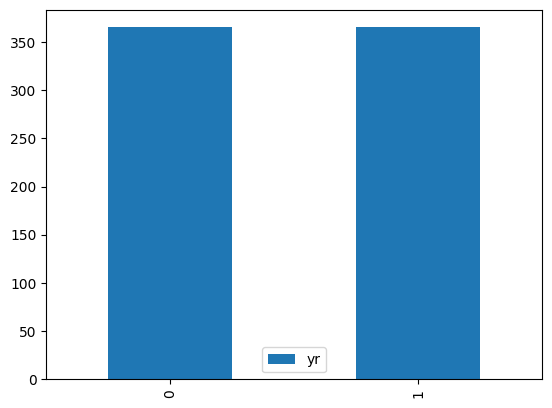

In [1033]:
bikedata.yr.value_counts().plot.bar()
plt.legend()
plt.show()

In [1034]:
bikedata.mnth.value_counts()

1     62
3     62
5     62
7     62
8     62
10    62
12    62
4     60
6     60
9     60
11    60
2     56
Name: mnth, dtype: int64

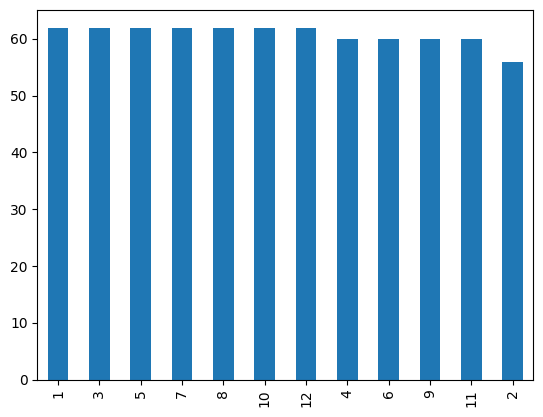

In [1035]:
bikedata.mnth.value_counts().plot.bar()
plt.show()

In [1036]:
bikedata.holiday.value_counts()

0    709
1     21
Name: holiday, dtype: int64

In [1037]:
bikedata.weekday.value_counts()

6    105
0    105
1    105
2    104
4    104
5    104
3    103
Name: weekday, dtype: int64

In [1038]:
bikedata.workingday.value_counts()

1    499
0    231
Name: workingday, dtype: int64

In [1039]:
bikedata.weathersit.value_counts()

1    463
2    246
3     21
Name: weathersit, dtype: int64

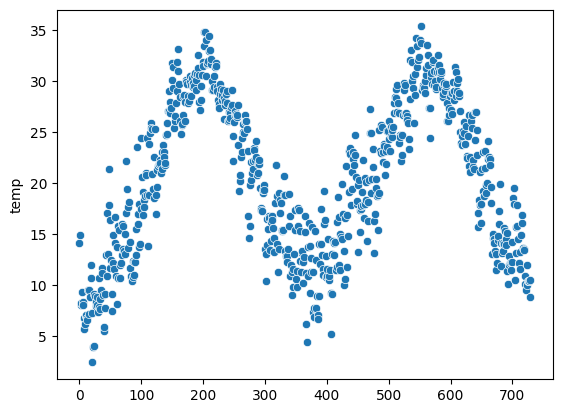

In [1040]:
sns.scatterplot(x=bikedata.index, y=bikedata.temp)
plt.show()

D:\python_project\upgrad\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


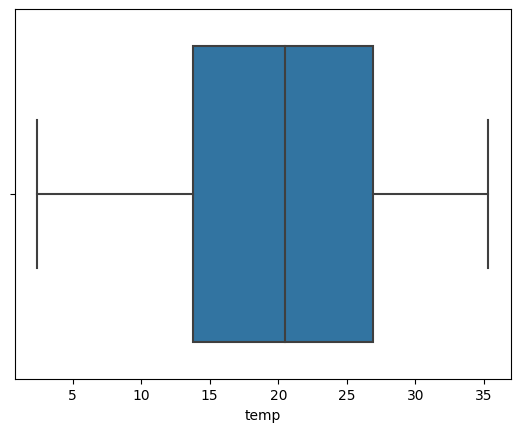

In [1041]:
sns.boxplot(bikedata.temp)
plt.show()

#### no outliers in temperature

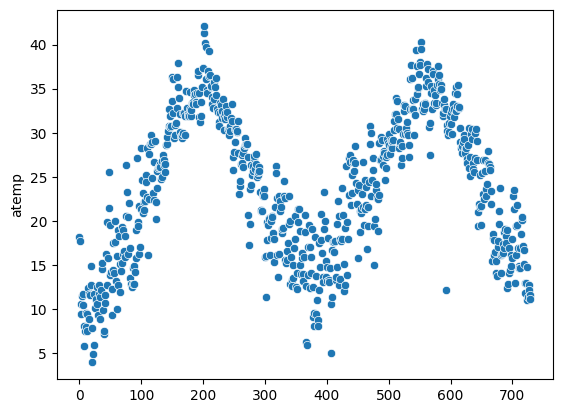

In [1042]:
sns.scatterplot(x=bikedata.index, y=bikedata.atemp)
plt.show()

D:\python_project\upgrad\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


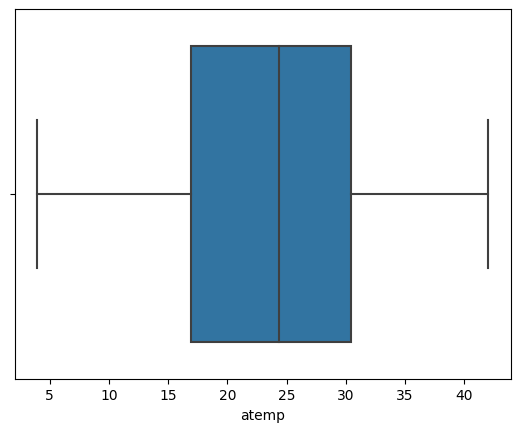

In [1043]:
sns.boxplot(bikedata.atemp)
plt.show()

### same conclusion as with the temp variable i.e no outliers

D:\python_project\upgrad\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


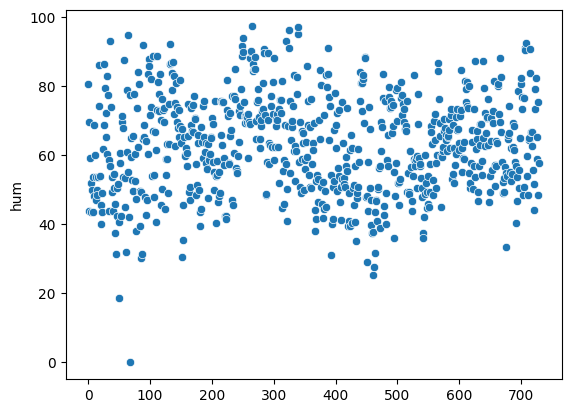

In [1044]:
sns.scatterplot(bikedata.index, bikedata.hum)
plt.show()

D:\python_project\upgrad\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


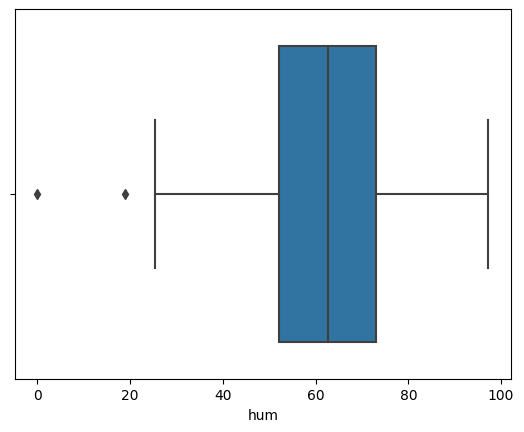

In [1045]:
sns.boxplot(bikedata.hum)
plt.show()

D:\python_project\upgrad\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


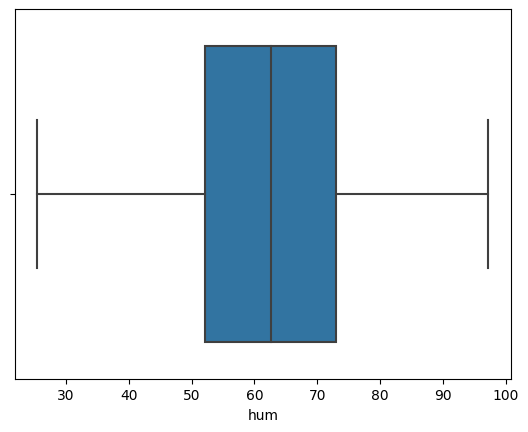

In [1046]:
remove_outliers('hum')
sns.boxplot(bikedata.hum)
plt.show()

In [1047]:
bikedata.head()

dteday  season  yr  mnth  holiday  weekday  workingday  weathersit  \
0 2018-01-01       1   0     1        0        6           0           2   
1 2018-01-02       1   0     1        0        0           0           2   
2 2018-01-03       1   0     1        0        1           1           1   
3 2018-01-04       1   0     1        0        2           1           1   
4 2018-01-05       1   0     1        0        3           1           1   

        temp     atemp      hum  windspeed   cnt  
0  14.110847  18.18125  80.5833  10.749882   985  
1  14.902598  17.68695  69.6087  16.652113   801  
2   8.050924   9.47025  43.7273  16.636703  1349  
3   8.200000  10.60610  59.0435  10.739832  1562  
4   9.305237  11.46350  43.6957  12.522300  1600

D:\python_project\upgrad\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


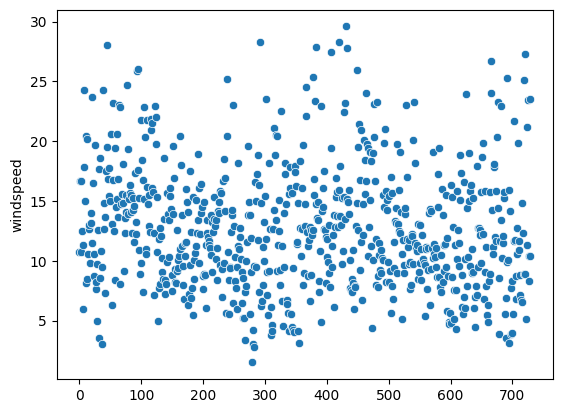

In [1048]:
sns.scatterplot(bikedata.index, bikedata.windspeed)
plt.show()

D:\python_project\upgrad\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


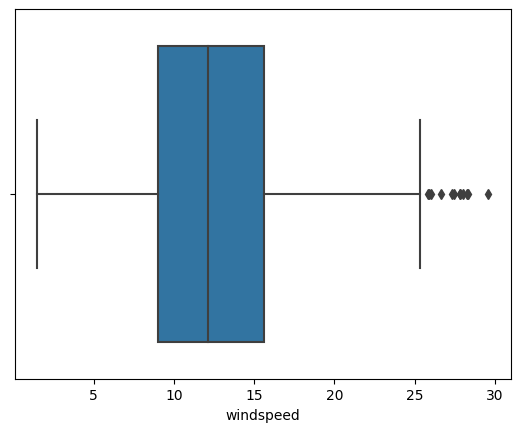

In [1049]:
sns.boxplot(bikedata.windspeed)
plt.show()

D:\python_project\upgrad\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


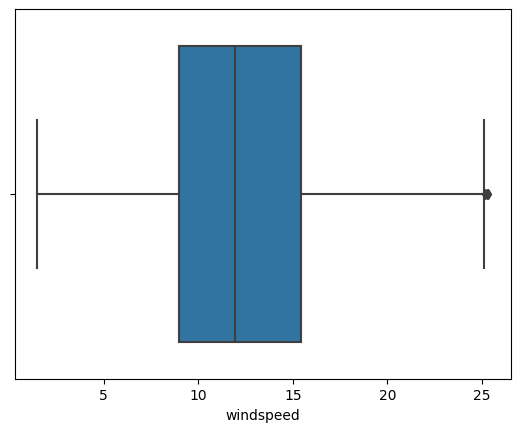

In [1050]:
remove_outliers('windspeed')
sns.boxplot(bikedata.windspeed)
plt.show()

D:\python_project\upgrad\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


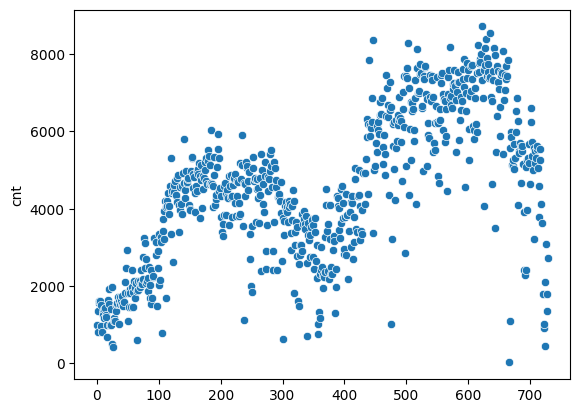

In [1051]:
sns.scatterplot(bikedata.index, bikedata.cnt)
plt.show()

D:\python_project\upgrad\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


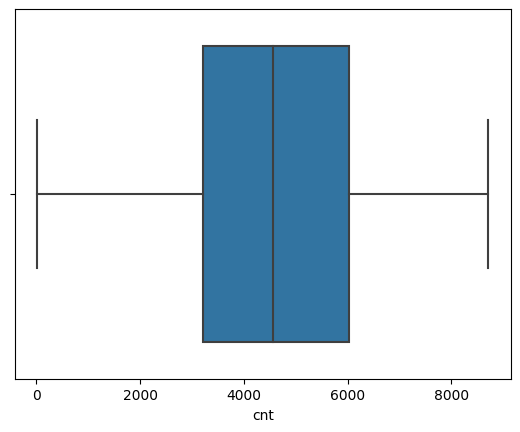

In [1052]:
sns.boxplot(bikedata.cnt)
plt.show()

## look at columns to check if contains single value

In [1053]:
print('Column Name', ' '*(15-len('Column Name')), 'Number of unique items in the column')
for col in bikedata:
    print(col, ' '*(15-len(col)),len(bikedata[col].value_counts()))

Column Name      Number of unique items in the column
dteday           716
season           4
yr               2
mnth             12
holiday          2
weekday          7
workingday       2
weathersit       3
temp             493
atemp            678
hum              585
windspeed        635
cnt              683


## derived metrics
we cannot use the date column as it is and need to derive some other attrbutes from it. Some of the attributes like weekday, month and year have already been extracted. We can extract a few more like day of the year and week of the year.

In [1054]:
bikedata['day_of_year'] = bikedata.dteday.dt.day_of_year
bikedata['week_of_year'] = bikedata.dteday.dt.weekofyear


C:\Users\z003hz2y\AppData\Local\Temp\ipykernel_3120\3125735740.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  bikedata['week_of_year'] = bikedata.dteday.dt.weekofyear


In [1055]:
bikedata = bikedata.reindex(columns=['dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
                          'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'day_of_year',
                          'week_of_year', 'cnt'])
bikedata.head(20)

dteday  season  yr  mnth  holiday  weekday  workingday  weathersit  \
0  2018-01-01       1   0     1        0        6           0           2   
1  2018-01-02       1   0     1        0        0           0           2   
2  2018-01-03       1   0     1        0        1           1           1   
3  2018-01-04       1   0     1        0        2           1           1   
4  2018-01-05       1   0     1        0        3           1           1   
5  2018-01-06       1   0     1        0        4           1           1   
6  2018-01-07       1   0     1        0        5           1           2   
7  2018-01-08       1   0     1        0        6           0           2   
8  2018-01-09       1   0     1        0        0           0           1   
9  2018-01-10       1   0     1        0        1           1           1   
10 2018-01-11       1   0     1        0        2           1           2   
11 2018-01-12       1   0     1        0        3           1           1   
12 2018-01-13       1   0     1        0        4           1           1   
13 2018-01-14       1   0     1        0        5           1           1   
14 2018-01-15       1   0     1        0        6           0           2   
15 2018-01-16       1   0     1        0        0           0           1   
16 2018-01-17       1   0     1        1        1           0           2   
17 2018-01-18       1   0     1        0        2           1           2   
18 2018-01-19       1   0     1        0        3           1           2   
19 2018-01-20       1   0     1        0        4           1           2   

         temp     atemp      hum  windspeed  day_of_year  week_of_year   cnt  
0   14.110847  18.18125  80.5833  10.749882            1             1   985  
1   14.902598  17.68695  69.6087  16.652113            2             1   801  
2    8.050924   9.47025  43.7273  16.636703            3             1  1349  
3    8.200000  10.60610  59.0435  10.739832            4             1  1562  
4    9.305237  11.46350  43.6957  12.522300            5             1  1600  
5    8.378268  11.66045  51.8261   6.000868            6             1  1606  
6    8.057402  10.44195  49.8696  11.304642            7             1  1510  
7    6.765000   8.11270  53.5833  17.875868            8             2   959  
8    5.671653   5.80875  43.4167  24.250650            9             2   822  
9    6.184153   7.54440  48.2917  14.958889           10             2  1321  
10   6.932731   9.57320  68.6364   8.182844           11             2  1263  
11   7.081807   8.02365  59.9545  20.410009           12             2  1162  
12   6.765000   7.54415  47.0417  20.167000           13             2  1406  
13   6.595670   9.42065  53.7826   8.478716           14             2  1421  
14   9.566653  12.40560  49.8750  10.583521           15             3  1248  
15   9.498347  11.71085  48.3750  12.625011           16             3  1204  
16   7.209153   8.83855  53.7500  12.999139           17             3  1000  
17   8.883347  11.61665  86.1667   9.833925           18             3   683  
18  11.979134  14.92110  74.1739  13.957239           19             3  1650  
19  10.728347  12.75250  53.8333  13.125568           20             3  1927

In [1056]:
# now drop dteday column
bikedata.drop('dteday', axis=1,inplace=True)

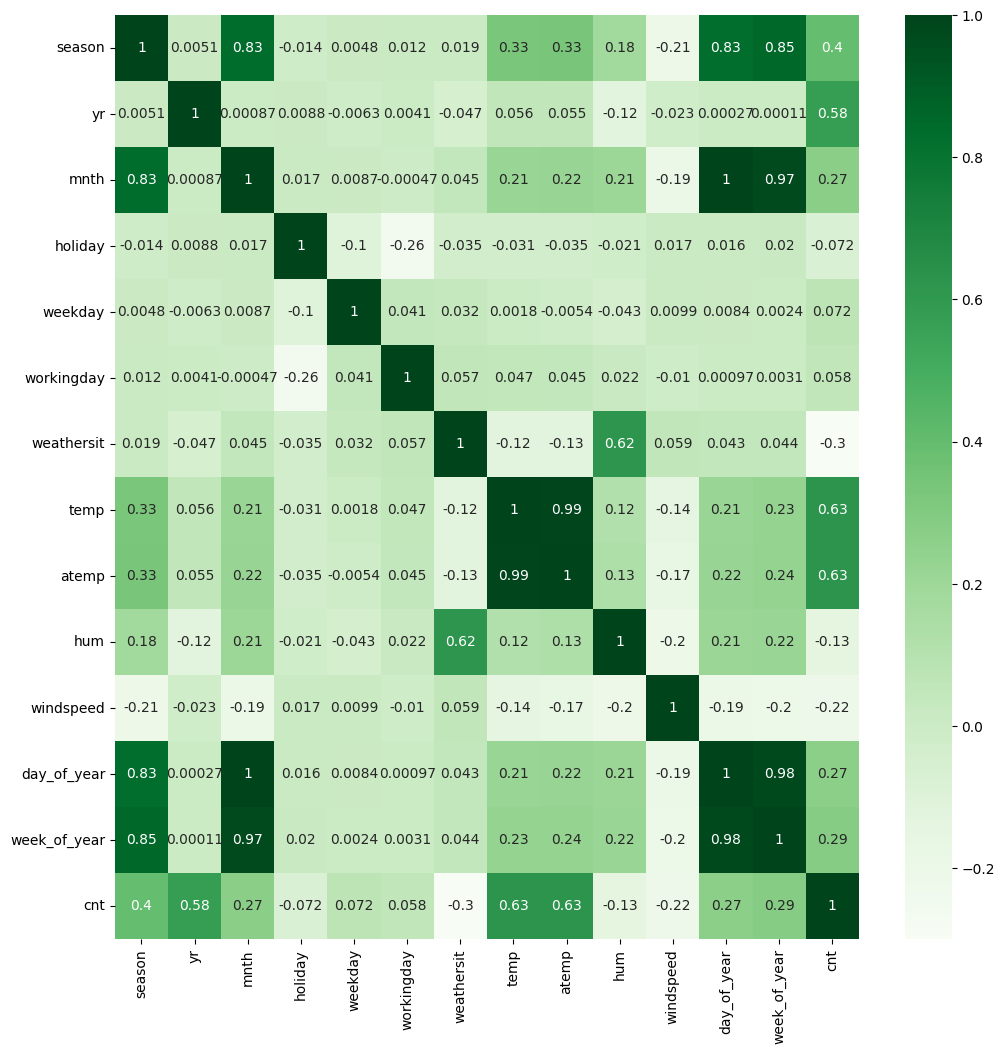

In [1057]:
plt.figure(figsize=(12,12))
sns.heatmap(bikedata.corr(), cmap='Greens', annot=True)
plt.show()

## Now check the dependency of the target variable on all the inputs

In [1058]:
bikedata.head()

season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed  day_of_year  week_of_year   cnt  
0  18.18125  80.5833  10.749882            1             1   985  
1  17.68695  69.6087  16.652113            2             1   801  
2   9.47025  43.7273  16.636703            3             1  1349  
3  10.60610  59.0435  10.739832            4             1  1562  
4  11.46350  43.6957  12.522300            5             1  1600

In [1059]:
def plot_cat_bar(var_name, mapper=None):
    bikedata.groupby(var_name).cnt.mean().plot.bar()
    plt.ylabel('cnt')
    if mapper:
        plt.xticks(range(len(mapper)), mapper.values())
    plt.show()

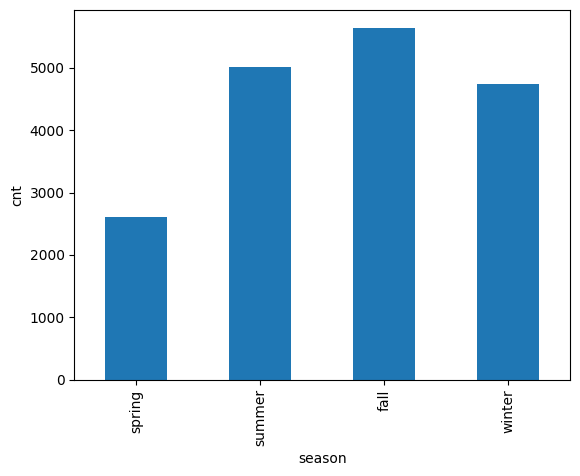

In [1060]:
plot_cat_bar('season', season_name_mapper)

#### this variable has a visible effect on the bike demand. During the summer and fall the demand is high owing to high temperature and chances of rain. During spring the demand is low as there maybe spring break and people may be preferring other means of public transport or be walking/cycling due to pleasnt weather

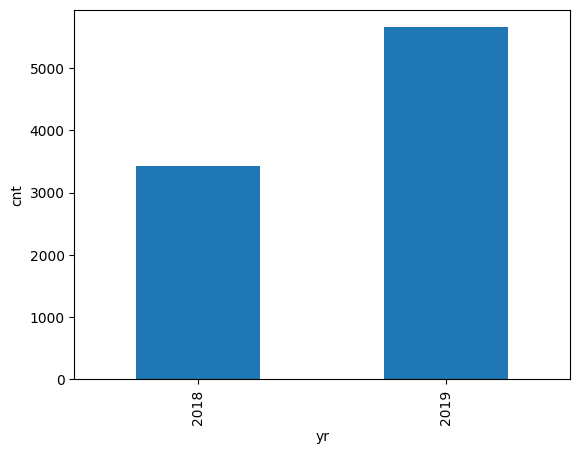

In [1061]:
plot_cat_bar('yr', year_mapper)

#### This variable also shows that year on year there is an increase in the bike demand. This may be attributed to growing population and awareness about bike sharing leading to people renting bikes rather than buying. This variable yr is a significant predictor of output cnt

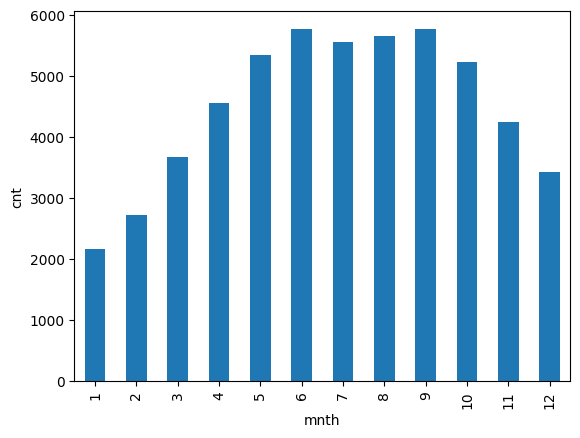

In [1062]:
plot_cat_bar('mnth', None)

#### This variable shows that during the months of May to Nov, we see an increased demand of bikes more likely due to high summer temperatures; and rainy season in which people want to quickly reach in a bike rather than wait for public transport or walk.

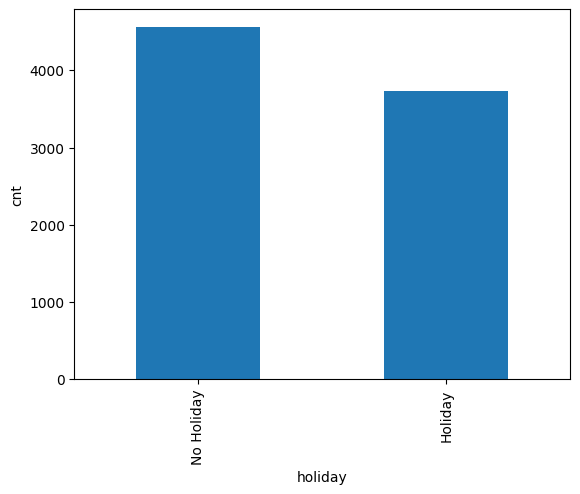

In [1063]:
plot_cat_bar('holiday', holiday_mapper)

#### This plot shows that during holiday the demand is lower because many people would stay at home relaxing than on 'No Holiday' when people would be commuting to colleges or work

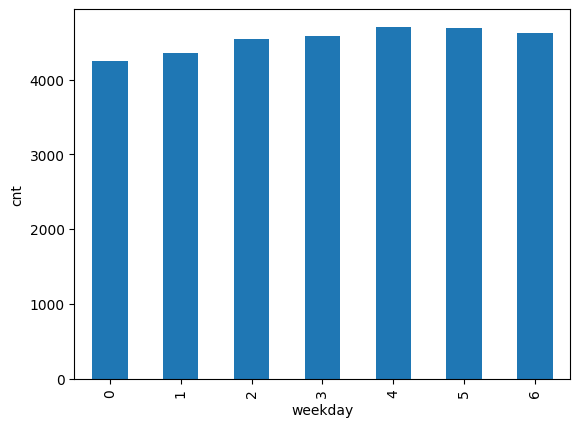

In [1064]:
plot_cat_bar('weekday', None)

#### There is some effect of weekday on the demand but it is not as profound as with previously seen variables. 

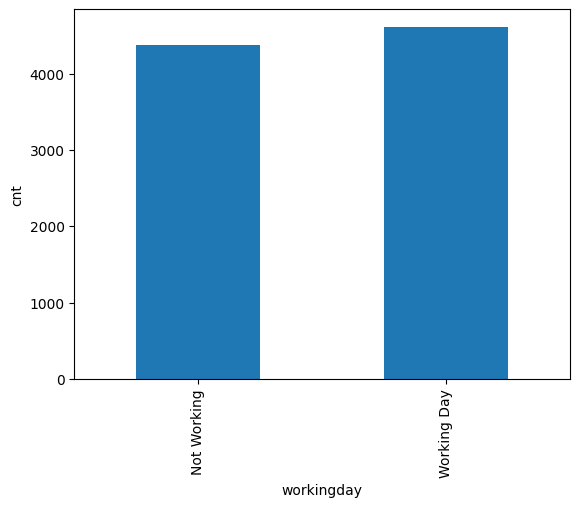

In [1065]:
plot_cat_bar('workingday', workingday_mapper)

#### This is unexpected and contrary to belief. We would expect that a workig day would have higher demand and not working day lower but that is not the case. This could be due having different businesses having different working days and not all establishments giving a day off on weekend.

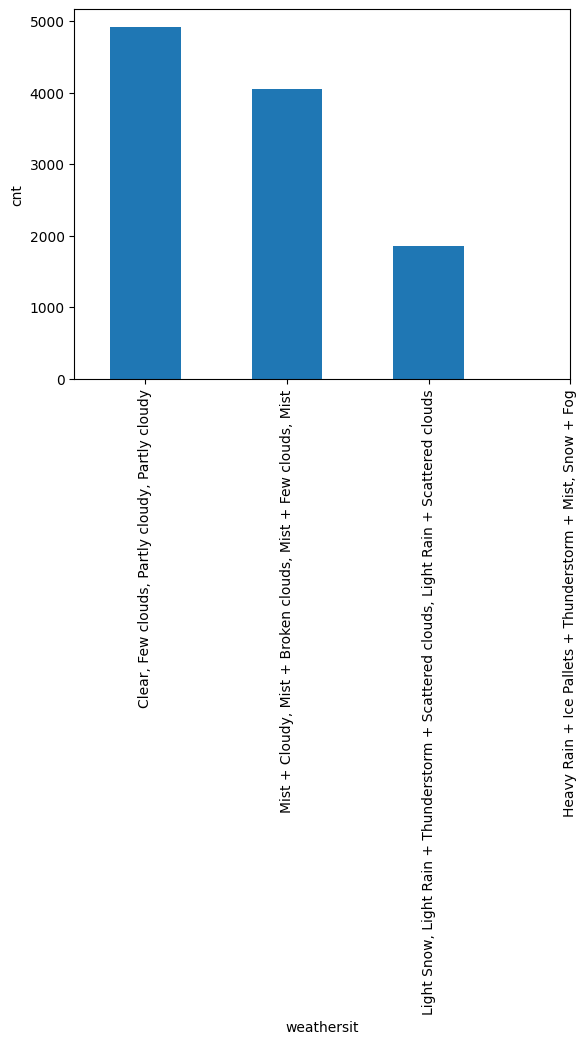

In [1066]:
plot_cat_bar('weathersit', weathersit_mapper)

#### This is as expected. People are renting bikes on a clearer day and not prefering bikes on a rainy day. This variable is very good predictor of `cnt`

In [1067]:
def plot_continuous_scatter(var_name, var_label=''):
    plt.scatter(bikedata[var_name], bikedata.cnt)
    if not var_label:
        var_label = var_name
    plt.xlabel(var_label)
    plt.ylabel('cnt')
    plt.show()
    print(f'Correlation of {var_label} and bike rent count:', bikedata[var_name].corr(bikedata.cnt))

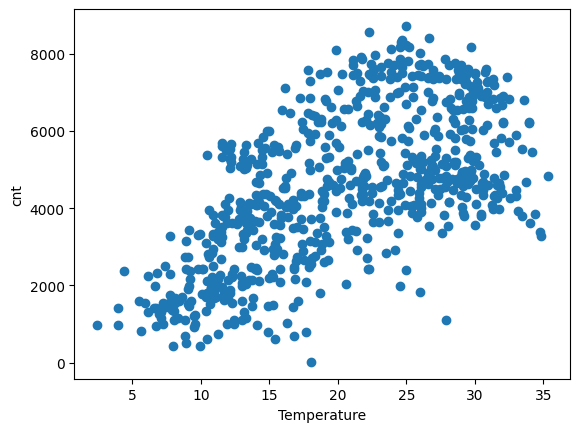

Correlation of Temperature and bike rent count: 0.6254209647953181


In [1068]:
plot_continuous_scatter('temp', 'Temperature')

#### We can clearly see a pattern here i.e. with increasing temperature, the demand of bikes increases. This could be due to people prefering bikes to escape the heat in public transport and during walk in the sun. This looks like a significant predictor for the `cnt`

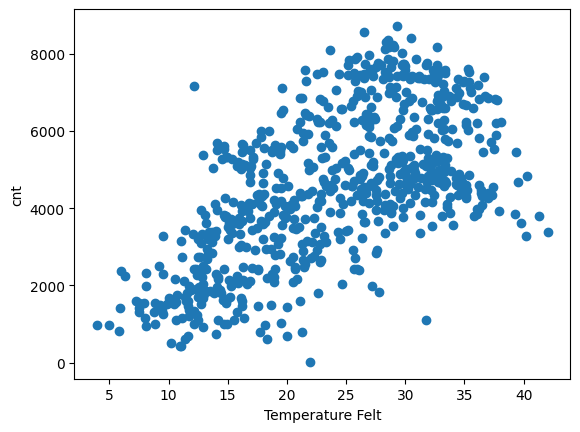

Correlation of Temperature Felt and bike rent count: 0.6288022371469149


In [1069]:
plot_continuous_scatter('atemp', 'Temperature Felt')

#### We can see the same pattern here as with temperature variable i.e. with increasing temperature felt, the demand of bikes increases. This also looks like a significant predictor for the cnt. Here the correlation is very slightly higher than with temperature.

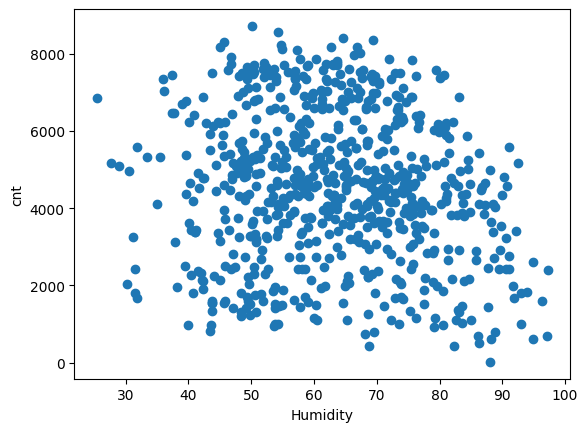

Correlation of Humidity and bike rent count: -0.1345214617847352


In [1070]:
plot_continuous_scatter('hum', 'Humidity')

#### There is not much pattern here and humidity in itself doesnt show much effect on the number of bikes rented.

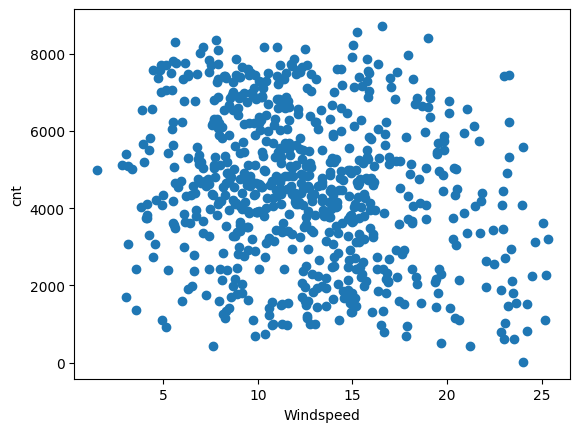

Correlation of Windspeed and bike rent count: -0.2166851859979996


In [1071]:
plot_continuous_scatter('windspeed', 'Windspeed')

#### Even windspeed on its own doesnt have much impact on the number of bikes rented and the same is visible with its correlation value as well.

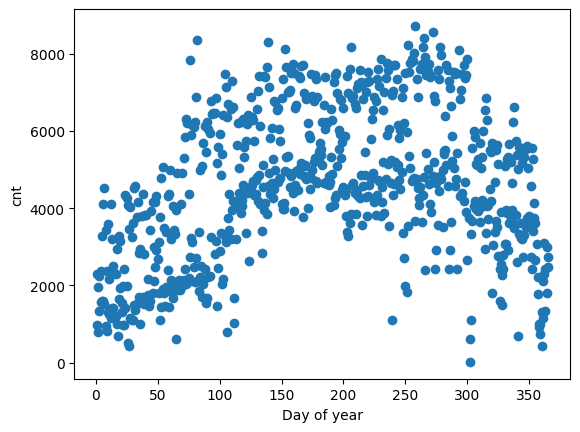

Correlation of Day of year and bike rent count: 0.268514827167295


In [1072]:
plot_continuous_scatter('day_of_year', 'Day of year')

#### Here we see that during the middle of the year the demand is higher and towards the beginning and end it is lower. This is also evident from the month and season plots and this particular variable doesnt necessarily give any extra information

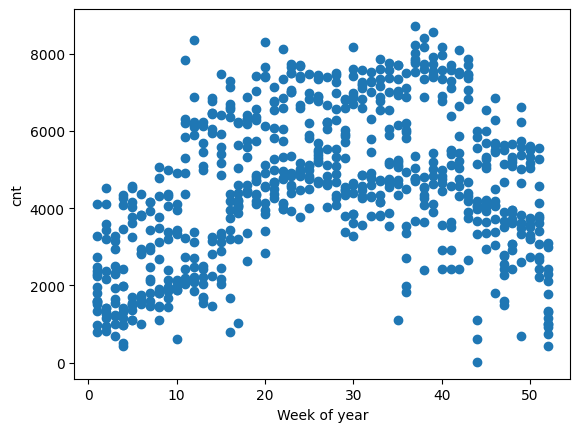

Correlation of Week of year and bike rent count: 0.2863791779333331


In [1073]:
plot_continuous_scatter('week_of_year', 'Week of year')

#### Here we see the same trend as with day of the year that during the middle of the year the demand is higher and towards the beginning and end it is lower. This is also evident from the month and season plots and this particular variable doesnt necessarily give any extra information

### convert `temp` and `atemp` into categorical to see if any new pattern or relation can be found

In [1074]:
bikedata['temp_cat'] = pd.cut(bikedata.temp, bins=[bikedata.temp.min(), 10, 15, 20, 25, 30, bikedata.temp.max()])

In [1075]:
bikedata['temp_cat'].value_counts()

(25.0, 30.0]      170
(10.0, 15.0]      157
(15.0, 20.0]      130
(20.0, 25.0]      128
(30.0, 35.328]     72
(2.424, 10.0]      58
Name: temp_cat, dtype: int64

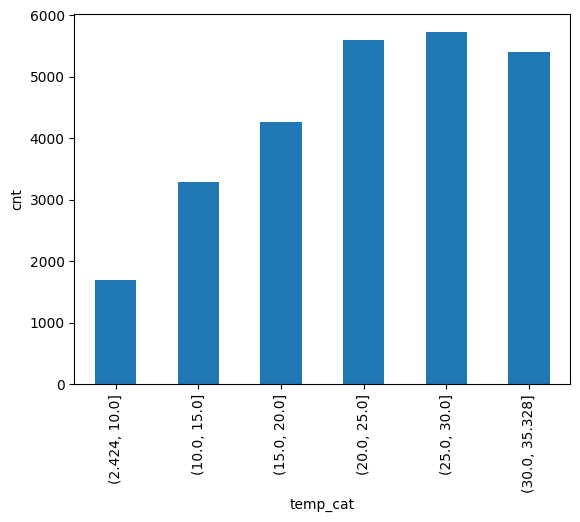

In [1076]:
bikedata.groupby('temp_cat').cnt.mean().plot.bar()
plt.ylabel('cnt')
plt.show()

#### This plot now shows the relation between temp and count of bikes rented more clearly. This variable is good to understand the relation but since we already have the actual data, we dont need this column for actual model building and hence we drop this

In [1077]:
bikedata.drop('temp_cat', axis=1,inplace=True)

(30.0, 42.045]    198
(25.0, 30.0]      154
(15.0, 20.0]      126
(20.0, 25.0]      109
(10.0, 15.0]      102
(3.953, 10.0]      26
Name: atemp_cat, dtype: int64


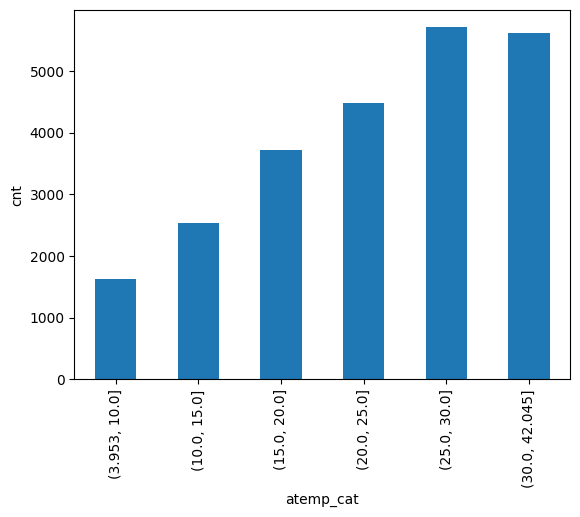

In [1078]:
bikedata['atemp_cat'] = pd.cut(bikedata.atemp, bins=[bikedata.atemp.min(), 10, 15, 20, 25, 30, bikedata.atemp.max()])
print(bikedata['atemp_cat'].value_counts())
bikedata.groupby('atemp_cat').cnt.mean().plot.bar()
plt.ylabel('cnt')
plt.show()

#### The trend here is similar to `temp` variable but there is one noticeable difference at 20-25 where in actual temperature plot the demand was higher but in atemp case the demand is lower. It could be understood that people feel the temperature higher than what it is actually and thus the demand shifts to another higher value of felt temperature. But here also we will drop this model before proceeding for regression model building as we have the actual variable values

In [1079]:
bikedata.drop('atemp_cat', axis=1, inplace=True)

# convert categorical variables into dummy variables

In [1080]:
bikedata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 716 entries, 0 to 729
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        716 non-null    int64  
 1   yr            716 non-null    int64  
 2   mnth          716 non-null    int64  
 3   holiday       716 non-null    int64  
 4   weekday       716 non-null    int64  
 5   workingday    716 non-null    int64  
 6   weathersit    716 non-null    int64  
 7   temp          716 non-null    float64
 8   atemp         716 non-null    float64
 9   hum           716 non-null    float64
 10  windspeed     716 non-null    float64
 11  day_of_year   716 non-null    int64  
 12  week_of_year  716 non-null    int64  
 13  cnt           716 non-null    int64  
dtypes: float64(4), int64(10)
memory usage: 83.9 KB


In [1081]:
bikedata.describe()

season          yr        mnth     holiday    weekday  workingday  \
count  716.000000  716.000000  716.000000  716.000000  716.00000  716.000000   
mean     2.515363    0.498603    6.568436    0.029330    2.99581    0.684358   
std      1.104872    0.500348    3.437280    0.168847    2.00314    0.465096   
min      1.000000    0.000000    1.000000    0.000000    0.00000    0.000000   
25%      2.000000    0.000000    4.000000    0.000000    1.00000    0.000000   
50%      3.000000    0.000000    7.000000    0.000000    3.00000    1.000000   
75%      3.000000    1.000000   10.000000    0.000000    5.00000    1.000000   
max      4.000000    1.000000   12.000000    1.000000    6.00000    1.000000   

       weathersit        temp       atemp         hum   windspeed  \
count  716.000000  716.000000  716.000000  716.000000  716.000000   
mean     1.395251   20.400717   23.821520   63.132034   12.481868   
std      0.543421    7.529887    8.159941   13.916864    4.812977   
min      1.000000    2.424346    3.953480   25.416700    1.500244   
25%      1.000000   13.828962   16.894537   52.458300    8.989859   
50%      1.000000   20.739153   24.605200   63.083300   11.958797   
75%      2.000000   26.931885   30.556050   73.260425   15.458374   
max      3.000000   35.328347   42.044800   97.250000   25.333236   

       day_of_year  week_of_year          cnt  
count   716.000000    716.000000   716.000000  
mean    184.287709     26.608939  4536.613128  
std     104.998746     14.999044  1932.256146  
min       1.000000      1.000000    22.000000  
25%      95.750000     14.000000  3214.000000  
50%     185.000000     27.000000  4572.500000  
75%     274.250000     39.250000  6031.750000  
max     365.000000     52.000000  8714.000000

In [1082]:
# convert season into dummy variables
season_dummy = pd.get_dummies(bikedata.season, drop_first=True, prefix='season')
season_dummy

season_2  season_3  season_4
0           0         0         0
1           0         0         0
2           0         0         0
3           0         0         0
4           0         0         0
..        ...       ...       ...
725         0         0         0
726         0         0         0
727         0         0         0
728         0         0         0
729         0         0         0

[716 rows x 3 columns]

In [1083]:
bikedata = pd.concat((season_dummy, bikedata), axis=1)
bikedata.head()

season_2  season_3  season_4  season  yr  mnth  holiday  weekday  \
0         0         0         0       1   0     1        0        6   
1         0         0         0       1   0     1        0        0   
2         0         0         0       1   0     1        0        1   
3         0         0         0       1   0     1        0        2   
4         0         0         0       1   0     1        0        3   

   workingday  weathersit       temp     atemp      hum  windspeed  \
0           0           2  14.110847  18.18125  80.5833  10.749882   
1           0           2  14.902598  17.68695  69.6087  16.652113   
2           1           1   8.050924   9.47025  43.7273  16.636703   
3           1           1   8.200000  10.60610  59.0435  10.739832   
4           1           1   9.305237  11.46350  43.6957  12.522300   

   day_of_year  week_of_year   cnt  
0            1             1   985  
1            2             1   801  
2            3             1  1349  
3            4             1  1562  
4            5             1  1600

In [1084]:
bikedata.columns

Index(['season_2', 'season_3', 'season_4', 'season', 'yr', 'mnth', 'holiday',
       'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum',
       'windspeed', 'day_of_year', 'week_of_year', 'cnt'],
      dtype='object')

In [1085]:
bikedata.drop(['season'], axis=1, inplace=True)

In [1086]:
cat_variables = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
# some categorical variables have value of 0 and 1 and thus dont need conversion into dummy variables
dummy_required_cat_variables = ['season', 'mnth', 'weekday', 'weathersit']
# since season has already been converted into dummy, we need to convert only the remaining ones
rem_dummy_required_cat_variables = ['mnth', 'weekday', 'weathersit']
for var in rem_dummy_required_cat_variables:
    var_dummy = pd.get_dummies(bikedata[var], drop_first=True, prefix=var)
    bikedata = pd.concat([bikedata, var_dummy], axis=1)
bikedata.head()

season_2  season_3  season_4  yr  mnth  holiday  weekday  workingday  \
0         0         0         0   0     1        0        6           0   
1         0         0         0   0     1        0        0           0   
2         0         0         0   0     1        0        1           1   
3         0         0         0   0     1        0        2           1   
4         0         0         0   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  day_of_year  \
0           2  14.110847  18.18125  80.5833  10.749882            1   
1           2  14.902598  17.68695  69.6087  16.652113            2   
2           1   8.050924   9.47025  43.7273  16.636703            3   
3           1   8.200000  10.60610  59.0435  10.739832            4   
4           1   9.305237  11.46350  43.6957  12.522300            5   

   week_of_year   cnt  mnth_2  mnth_3  mnth_4  mnth_5  mnth_6  mnth_7  mnth_8  \
0             1   985       0       0       0       0       0       0       0   
1             1   801       0       0       0       0       0       0       0   
2             1  1349       0       0       0       0       0       0       0   
3             1  1562       0       0       0       0       0       0       0   
4             1  1600       0       0       0       0       0       0       0   

   mnth_9  mnth_10  mnth_11  mnth_12  weekday_1  weekday_2  weekday_3  \
0       0        0        0        0          0          0          0   
1       0        0        0        0          0          0          0   
2       0        0        0        0          1          0          0   
3       0        0        0        0          0          1          0   
4       0        0        0        0          0          0          1   

   weekday_4  weekday_5  weekday_6  weathersit_2  weathersit_3  
0          0          0          1             1             0  
1          0          0          0             1             0  
2          0          0          0             0             0  
3          0          0          0             0             0  
4          0          0          0             0             0

In [1087]:
# remove categorical variables which have been converted into dummy
bikedata.drop(rem_dummy_required_cat_variables, axis=1,inplace=True)

In [1088]:
# re-arrange the columns, put `cnt` at the end
print(bikedata.columns)
bikedata = bikedata.reindex(columns=['season_2', 'season_3', 'season_4', 'yr', 'holiday', 'workingday',
       'temp', 'atemp', 'hum', 'windspeed', 'day_of_year', 'week_of_year',
       'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8',
       'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_2',
       'weathersit_3', 'cnt'])
print(bikedata.columns)

Index(['season_2', 'season_3', 'season_4', 'yr', 'holiday', 'workingday',
       'temp', 'atemp', 'hum', 'windspeed', 'day_of_year', 'week_of_year',
       'cnt', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7',
       'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
       'weathersit_2', 'weathersit_3'],
      dtype='object')
Index(['season_2', 'season_3', 'season_4', 'yr', 'holiday', 'workingday',
       'temp', 'atemp', 'hum', 'windspeed', 'day_of_year', 'week_of_year',
       'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8',
       'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_2',
       'weathersit_3', 'cnt'],
      dtype='object')


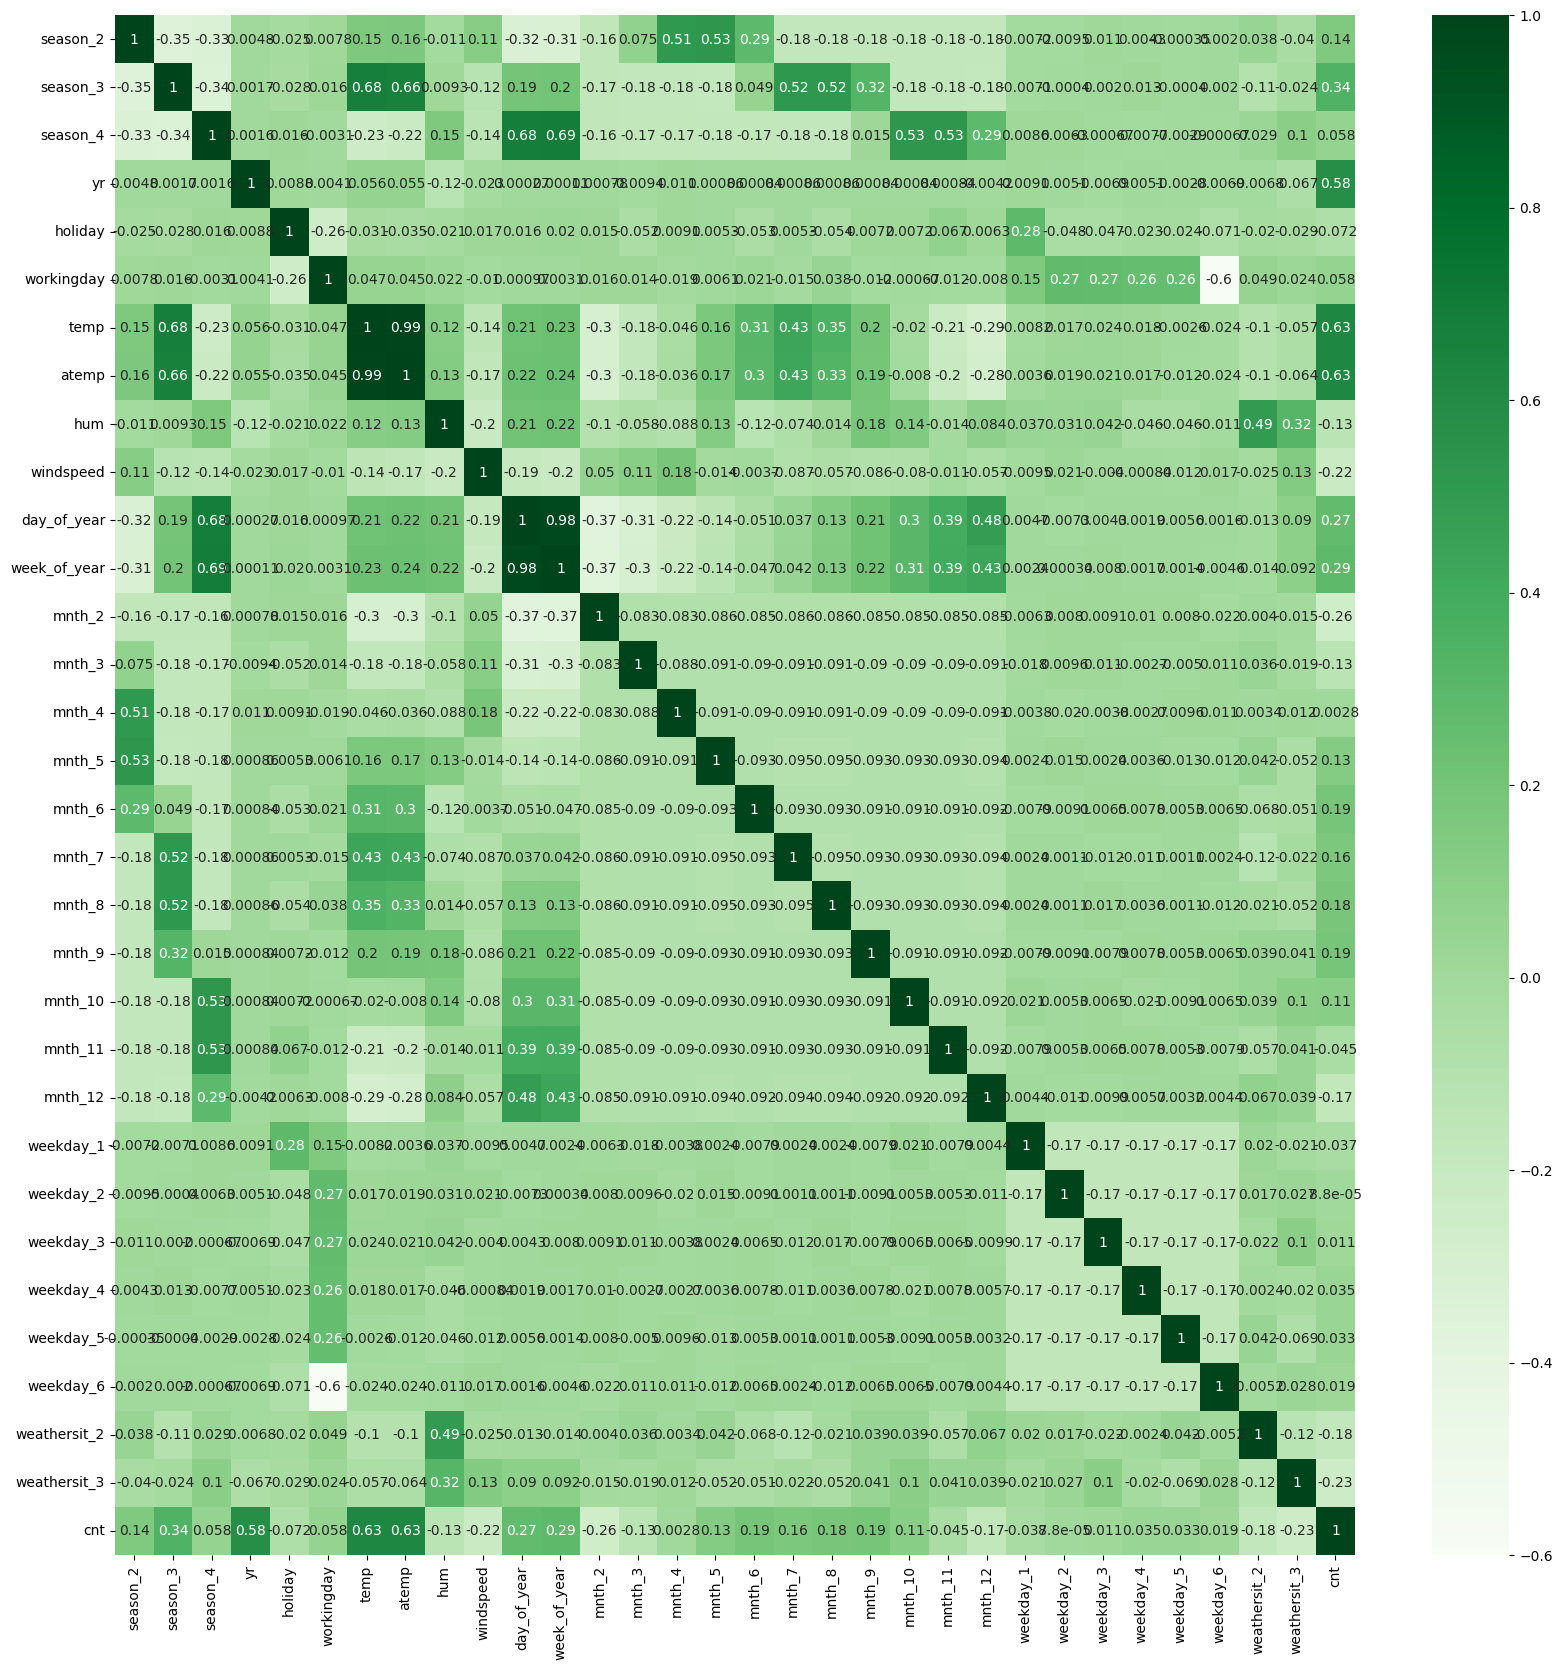

In [1089]:
plt.figure(figsize=(20,20))
sns.heatmap(bikedata.corr(), cmap='Greens', annot=True)
plt.show()

In [1090]:
bikedata.shape

(716, 32)

# data modelling

## train-test split

In [1091]:
bikedata_train, bikedata_test = train_test_split(bikedata, train_size=0.7, random_state=100)

## use MinMaxScaler to rescale the features on the training data

In [1092]:
pd.set_option('display.max_columns', 35)
bikedata_train.describe()

season_2    season_3    season_4          yr     holiday  workingday  \
count  501.000000  501.000000  501.000000  501.000000  501.000000  501.000000   
mean     0.241517    0.271457    0.245509    0.504990    0.031936    0.682635   
std      0.428431    0.445156    0.430819    0.500475    0.176006    0.465916   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    1.000000    0.000000    1.000000   
75%      0.000000    1.000000    0.000000    1.000000    0.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

             temp       atemp         hum   windspeed  day_of_year  \
count  501.000000  501.000000  501.000000  501.000000   501.000000   
mean    20.181491   23.543966   63.235618   12.510026   185.716567   
std      7.536327    8.159166   13.865498    4.929806   106.865446   
min      2.424346    3.953480   29.000000    1.500244     1.000000   
25%     13.393347   16.224150   52.958300    9.041650    92.000000   
50%     20.260847   24.115200   63.333300   11.792000   187.000000   
75%     26.923347   30.398750   73.458300   15.458575   277.000000   
max     34.371653   41.318550   94.958300   25.333236   365.000000   

       week_of_year      mnth_2      mnth_3      mnth_4     mnth_5  \
count    501.000000  501.000000  501.000000  501.000000  501.00000   
mean      26.820359    0.065868    0.085828    0.075848    0.08982   
std       15.268519    0.248300    0.280390    0.265020    0.28621   
min        1.000000    0.000000    0.000000    0.000000    0.00000   
25%       14.000000    0.000000    0.000000    0.000000    0.00000   
50%       27.000000    0.000000    0.000000    0.000000    0.00000   
75%       40.000000    0.000000    0.000000    0.000000    0.00000   
max       52.000000    1.000000    1.000000    1.000000    1.00000   

           mnth_6      mnth_7      mnth_8      mnth_9     mnth_10    mnth_11  \
count  501.000000  501.000000  501.000000  501.000000  501.000000  501.00000   
mean     0.069860    0.087824    0.087824    0.087824    0.077844    0.08982   
std      0.255166    0.283322    0.283322    0.283322    0.268194    0.28621   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.00000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.00000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.00000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.00000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.00000   

         mnth_12   weekday_1   weekday_2   weekday_3   weekday_4   weekday_5  \
count  501.00000  501.000000  501.000000  501.000000  501.000000  501.000000   
mean     0.08982    0.159681    0.129741    0.141717    0.139721    0.143713   
std      0.28621    0.366676    0.336354    0.349108    0.347043    0.351149   
min      0.00000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.00000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.00000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.00000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.00000    1.000000    1.000000    1.000000    1.000000    1.000000   

        weekday_6  weathersit_2  weathersit_3          cnt  
count  501.000000    501.000000    501.000000   501.000000  
mean     0.141717      0.365269      0.023952  4538.129741  
std      0.349108      0.481987      0.153053  1966.611232  
min      0.000000      0.000000      0.000000    22.000000  
25%      0.000000      0.000000      0.000000  3141.000000  
50%      0.000000      0.000000      0.000000  4563.000000  
75%      0.000000      1.000000      0.000000  6043.000000  
max      1.000000      1.000000      1.000000  8714.000000

In [1093]:
vars_to_scale = ['temp', 'atemp', 'hum', 'windspeed', 'day_of_year', 'week_of_year', 'cnt']
scaler = MinMaxScaler()
bikedata_train[vars_to_scale] = scaler.fit_transform(bikedata_train[vars_to_scale])

In [1094]:
bikedata_train.describe()

season_2    season_3    season_4          yr     holiday  workingday  \
count  501.000000  501.000000  501.000000  501.000000  501.000000  501.000000   
mean     0.241517    0.271457    0.245509    0.504990    0.031936    0.682635   
std      0.428431    0.445156    0.430819    0.500475    0.176006    0.465916   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    1.000000    0.000000    1.000000   
75%      0.000000    1.000000    0.000000    1.000000    0.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

             temp       atemp         hum   windspeed  day_of_year  \
count  501.000000  501.000000  501.000000  501.000000   501.000000   
mean     0.555826    0.524299    0.519049    0.461956     0.507463   
std      0.235899    0.218363    0.210216    0.206848     0.293586   
min      0.000000    0.000000    0.000000    0.000000     0.000000   
25%      0.343347    0.328399    0.363234    0.316427     0.250000   
50%      0.558310    0.539587    0.520530    0.431828     0.510989   
75%      0.766857    0.707754    0.674036    0.585673     0.758242   
max      1.000000    1.000000    1.000000    1.000000     1.000000   

       week_of_year      mnth_2      mnth_3      mnth_4     mnth_5  \
count    501.000000  501.000000  501.000000  501.000000  501.00000   
mean       0.506282    0.065868    0.085828    0.075848    0.08982   
std        0.299383    0.248300    0.280390    0.265020    0.28621   
min        0.000000    0.000000    0.000000    0.000000    0.00000   
25%        0.254902    0.000000    0.000000    0.000000    0.00000   
50%        0.509804    0.000000    0.000000    0.000000    0.00000   
75%        0.764706    0.000000    0.000000    0.000000    0.00000   
max        1.000000    1.000000    1.000000    1.000000    1.00000   

           mnth_6      mnth_7      mnth_8      mnth_9     mnth_10    mnth_11  \
count  501.000000  501.000000  501.000000  501.000000  501.000000  501.00000   
mean     0.069860    0.087824    0.087824    0.087824    0.077844    0.08982   
std      0.255166    0.283322    0.283322    0.283322    0.268194    0.28621   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.00000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.00000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.00000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.00000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.00000   

         mnth_12   weekday_1   weekday_2   weekday_3   weekday_4   weekday_5  \
count  501.00000  501.000000  501.000000  501.000000  501.000000  501.000000   
mean     0.08982    0.159681    0.129741    0.141717    0.139721    0.143713   
std      0.28621    0.366676    0.336354    0.349108    0.347043    0.351149   
min      0.00000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.00000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.00000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.00000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.00000    1.000000    1.000000    1.000000    1.000000    1.000000   

        weekday_6  weathersit_2  weathersit_3         cnt  
count  501.000000    501.000000    501.000000  501.000000  
mean     0.141717      0.365269      0.023952    0.519573  
std      0.349108      0.481987      0.153053    0.226255  
min      0.000000      0.000000      0.000000    0.000000  
25%      0.000000      0.000000      0.000000    0.358836  
50%      0.000000      0.000000      0.000000    0.522434  
75%      0.000000      1.000000      0.000000    0.692706  
max      1.000000      1.000000      1.000000    1.000000

## use all the features to build a model and check if its r2 and adjusted r2 score

In [1095]:
X_train_lm = sm.add_constant(X_train)
lm = sm.OLS(y_train, X_train_lm)
lm_model = lm.fit()
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.853
Method:                 Least Squares   F-statistic:                     98.04
Date:                Wed, 12 Oct 2022   Prob (F-statistic):          1.79e-181
Time:                        00:05:28   Log-Likelihood:                 530.66
No. Observations:                 501   AIC:                            -999.3
Df Residuals:                     470   BIC:                            -868.6
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1432      0.025      5.749      0.000       0.094       0.192
season_2         0.0810      0.024      3.354      0.001       0.034       0.128
season_3         0.0696      0.030      2.353      0.019       0.011       0.128
season_4         0.1754      0.025      7.013      0.000       0.126       0.224
yr               0.2304      0.008     28.637      0.000       0.215       0.246
holiday         -0.0340      0.021     -1.614      0.107      -0.075       0.007
workingday       0.0342      0.009      3.778      0.000       0.016       0.052
temp             0.3239      0.135      2.396      0.017       0.058       0.590
atemp            0.1207      0.134      0.900      0.368      -0.143       0.384
hum             -0.1312      0.028     -4.697      0.000      -0.186      -0.076
windspeed       -0.1152      0.021     -5.398      0.000      -0.157      -0.073
day_of_year     -0.2393      0.169     -1.415      0.158      -0.572       0.093
week_of_year     0.0667      0.065      1.029      0.304      -0.061       0.194
mnth_2           0.0497      0.024      2.044      0.042       0.002       0.097
mnth_3           0.1092      0.035      3.156      0.002       0.041       0.177
mnth_4           0.1105      0.050      2.197      0.029       0.012       0.209
mnth_5           0.1560      0.064      2.444      0.015       0.031       0.281
mnth_6           0.1375      0.077      1.784      0.075      -0.014       0.289
mnth_7           0.1237      0.091      1.365      0.173      -0.054       0.302
mnth_8           0.1710      0.103      1.655      0.099      -0.032       0.374
mnth_9           0.2545      0.113      2.246      0.025       0.032       0.477
mnth_10          0.1880      0.127      1.481      0.139      -0.062       0.437
mnth_11          0.1331      0.140      0.952      0.342      -0.142       0.408
mnth_12          0.1687      0.151      1.115      0.265      -0.129       0.466
weekday_1       -0.0164      0.009     -1.745      0.082      -0.035       0.002
weekday_2       -0.0022      0.011     -0.202      0.840      -0.024       0.019
weekday_3        0.0118      0.011      1.115      0.265      -0.009       0.032
weekday_4       -0.0100      0.010     -0.953      0.341      -0.031       0.011
weekday_5        0.0171      0.010      1.636      0.102      -0.003       0.038
weekday_6        0.0595      0.015      4.056      0.000       0.031       0.088
weathersit_2    -0.0442      0.011     -4.199      0.000      -0.065      -0.024
weathersit_3    -0.2001      0.030     -6.626      0.000      -0.259      -0.141
==============================================================================
Omnibus:                       64.346   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              149.527
Skew:      

#### it has good score and a good AIC score but it has 14 variables with p>=0.05 and thus 14 insignificant variables and thus we cannot use this model as it is

## use RFE to reduce the number of variables from 31 to 15

In [1096]:
# create X and y of training data
y_train = bikedata_train.pop('cnt')
X_train = bikedata_train

In [1097]:
lin_model = LinearRegression()
selector = RFE(estimator=lin_model, n_features_to_select=15)
selector.fit(X_train, y_train)


RFE(estimator=LinearRegression(), n_features_to_select=15)

In [1098]:
list(zip(X_train.columns, selector.support_, selector.ranking_))

[('season_2', True, 1),
 ('season_3', True, 1),
 ('season_4', True, 1),
 ('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 12),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('day_of_year', False, 4),
 ('week_of_year', True, 1),
 ('mnth_2', False, 9),
 ('mnth_3', True, 1),
 ('mnth_4', False, 3),
 ('mnth_5', False, 2),
 ('mnth_6', False, 6),
 ('mnth_7', False, 5),
 ('mnth_8', False, 8),
 ('mnth_9', True, 1),
 ('mnth_10', False, 7),
 ('mnth_11', True, 1),
 ('mnth_12', True, 1),
 ('weekday_1', False, 15),
 ('weekday_2', False, 17),
 ('weekday_3', False, 14),
 ('weekday_4', False, 16),
 ('weekday_5', False, 13),
 ('weekday_6', False, 11),
 ('weathersit_2', False, 10),
 ('weathersit_3', True, 1)]

In [1099]:
selected_columns = X_train.columns[selector.support_]
selected_columns

Index(['season_2', 'season_3', 'season_4', 'yr', 'holiday', 'temp', 'atemp',
       'hum', 'windspeed', 'week_of_year', 'mnth_3', 'mnth_9', 'mnth_11',
       'mnth_12', 'weathersit_3'],
      dtype='object')

In [1100]:
X_train_rfe = X_train[selected_columns]
X_train_rfe.head()

season_2  season_3  season_4  yr  holiday      temp     atemp       hum  \
728         0         0         0   1        0  0.252441  0.204242  0.293114   
541         0         1         0   1        0  0.733702  0.689995  0.126342   
116         1         0         0   0        0  0.719799  0.663818  0.826912   
718         0         0         1   1        0  0.347624  0.342763  0.572964   
496         1         0         0   1        0  0.648145  0.623239  0.288693   

     windspeed  week_of_year  mnth_3  mnth_9  mnth_11  mnth_12  weathersit_3  
728   0.923102      0.000000       0       0        0        1             0  
541   0.914353      0.490196       0       0        0        0             0  
116   0.814718      0.313725       0       0        0        0             0  
718   0.309436      0.980392       0       0        0        1             0  
496   0.283207      0.352941       0       0        0        0             0

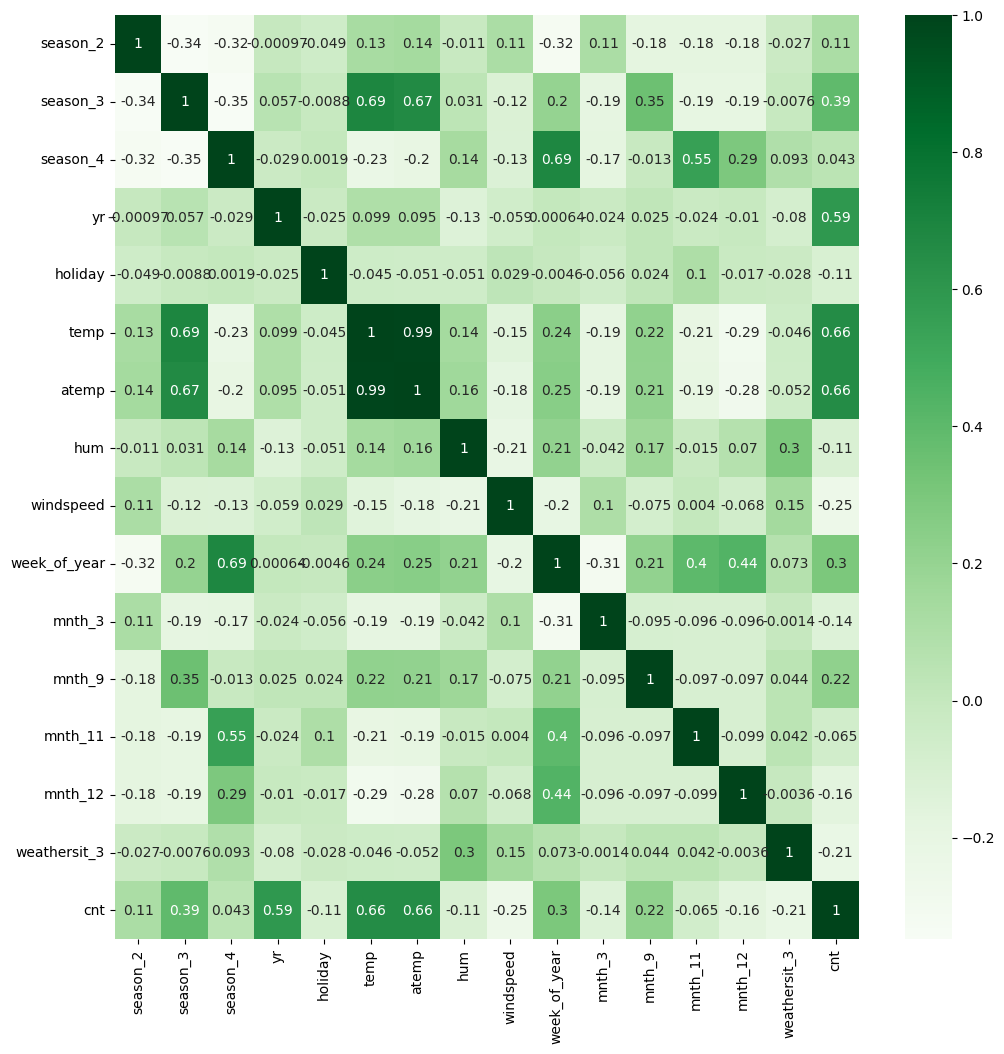

In [1101]:
plt.figure(figsize=(12,12))
sns.heatmap(pd.concat((X_train_rfe, y_train), axis=1).corr(), cmap='Greens', annot=True)
plt.show()

### let's reduce the number of features in the model manually using the statsmodels

In [1102]:
X_train_lm = sm.add_constant(X_train_rfe)

In [1103]:
lm = sm.OLS(y_train, X_train_lm)
lm_model = lm.fit()

In [1104]:
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     177.9
Date:                Wed, 12 Oct 2022   Prob (F-statistic):          4.17e-186
Time:                        00:05:30   Log-Likelihood:                 503.15
No. Observations:                 501   AIC:                            -974.3
Df Residuals:                     485   BIC:                            -906.8
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1913      0.022      8.889      0.000       0.149       0.234
season_2         0.1097      0.016      6.948      0.000       0.079       0.141
season_3         0.0565      0.024      2.384      0.017       0.010       0.103
season_4         0.1616      0.024      6.761      0.000       0.115       0.209
yr               0.2268      0.008     27.494      0.000       0.211       0.243
holiday         -0.0776      0.023     -3.340      0.001      -0.123      -0.032
temp             0.3939      0.132      2.990      0.003       0.135       0.653
atemp            0.0895      0.136      0.659      0.510      -0.177       0.356
hum             -0.1956      0.022     -8.873      0.000      -0.239      -0.152
windspeed       -0.1298      0.021     -6.053      0.000      -0.172      -0.088
week_of_year     0.0698      0.039      1.802      0.072      -0.006       0.146
mnth_3           0.0360      0.015      2.344      0.019       0.006       0.066
mnth_9           0.0826      0.017      4.972      0.000       0.050       0.115
mnth_11         -0.0668      0.022     -3.096      0.002      -0.109      -0.024
mnth_12         -0.0622      0.025     -2.481      0.013      -0.111      -0.013
weathersit_3    -0.1610      0.029     -5.597      0.000      -0.217      -0.104
==============================================================================
Omnibus:                       61.438   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.035
Skew:                          -0.730   Prob(JB):                     1.73e-25
Kurtosis:                       4.825   Cond. No.                         79.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1105]:
vif=pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

Features    VIF
6           temp  59.51
7          atemp  54.17
0          const  28.60
10  week_of_year   8.30
2       season_3   6.85
3       season_4   6.54
14       mnth_12   3.17
1       season_2   2.82
13       mnth_11   2.35
12        mnth_9   1.36
8            hum   1.32
9      windspeed   1.21
15  weathersit_3   1.19
11        mnth_3   1.15
4             yr   1.05
5        holiday   1.03

### Here, we see that `atemp` variable is shown to be insignificant due to its value of 0.51 much greater than the limit of 0.05. Its VIF is also very high. Thus, we drop this variable. This is what we had intially thought towards the beginning based on our logic and thought process

In [1106]:
X_train_lm.drop('atemp', axis=1, inplace=True)

In [1107]:
lm = sm.OLS(y_train, X_train_lm)
lm_model = lm.fit()
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     190.8
Date:                Wed, 12 Oct 2022   Prob (F-statistic):          3.68e-187
Time:                        00:05:30   Log-Likelihood:                 502.93
No. Observations:                 501   AIC:                            -975.9
Df Residuals:                     486   BIC:                            -912.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1930      0.021      9.035      0.000       0.151       0.235
season_2         0.1100      0.016      6.974      0.000       0.079       0.141
season_3         0.0553      0.024      2.343      0.020       0.009       0.102
season_4         0.1622      0.024      6.794      0.000       0.115       0.209
yr               0.2266      0.008     27.502      0.000       0.210       0.243
holiday         -0.0782      0.023     -3.370      0.001      -0.124      -0.033
temp             0.4775      0.036     13.389      0.000       0.407       0.548
hum             -0.1947      0.022     -8.854      0.000      -0.238      -0.151
windspeed       -0.1326      0.021     -6.313      0.000      -0.174      -0.091
week_of_year     0.0692      0.039      1.787      0.075      -0.007       0.145
mnth_3           0.0362      0.015      2.356      0.019       0.006       0.066
mnth_9           0.0831      0.017      5.010      0.000       0.051       0.116
mnth_11         -0.0662      0.022     -3.073      0.002      -0.109      -0.024
mnth_12         -0.0617      0.025     -2.467      0.014      -0.111      -0.013
weathersit_3    -0.1616      0.029     -5.625      0.000      -0.218      -0.105
==============================================================================
Omnibus:                       60.081   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              110.289
Skew:                          -0.720   Prob(JB):                     1.12e-24
Kurtosis:                       4.791   Cond. No.                         20.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1108]:
vif=pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

Features    VIF
0          const  28.20
9   week_of_year   8.29
2       season_3   6.81
3       season_4   6.53
6           temp   4.37
13       mnth_12   3.17
1       season_2   2.82
12       mnth_11   2.34
11        mnth_9   1.36
7            hum   1.32
14  weathersit_3   1.19
8      windspeed   1.16
10        mnth_3   1.15
4             yr   1.05
5        holiday   1.03

### here the `week_of_year` variable is not significant because the p value is greater than 0.05 and its VIF is also more than 5. So we drop this variable

In [1109]:
X_train_lm.drop('week_of_year', axis=1, inplace=True)

In [1110]:
lm = sm.OLS(y_train, X_train_lm)
lm_model = lm.fit()

In [1111]:
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     204.3
Date:                Wed, 12 Oct 2022   Prob (F-statistic):          1.23e-187
Time:                        00:05:30   Log-Likelihood:                 501.29
No. Observations:                 501   AIC:                            -974.6
Df Residuals:                     487   BIC:                            -915.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1957      0.021      9.166      0.000       0.154       0.238
season_2         0.1168      0.015      7.608      0.000       0.087       0.147
season_3         0.0737      0.021      3.462      0.001       0.032       0.116
season_4         0.1933      0.016     11.780      0.000       0.161       0.226
yr               0.2259      0.008     27.387      0.000       0.210       0.242
holiday         -0.0787      0.023     -3.384      0.001      -0.124      -0.033
temp             0.4993      0.034     14.865      0.000       0.433       0.565
hum             -0.1922      0.022     -8.741      0.000      -0.235      -0.149
windspeed       -0.1333      0.021     -6.333      0.000      -0.175      -0.092
mnth_3           0.0353      0.015      2.293      0.022       0.005       0.066
mnth_9           0.0918      0.016      5.780      0.000       0.061       0.123
mnth_11         -0.0478      0.019     -2.520      0.012      -0.085      -0.011
mnth_12         -0.0285      0.017     -1.698      0.090      -0.062       0.004
weathersit_3    -0.1603      0.029     -5.571      0.000      -0.217      -0.104
==============================================================================
Omnibus:                       50.119   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               83.750
Skew:                          -0.649   Prob(JB):                     6.52e-19
Kurtosis:                       4.526   Cond. No.                         16.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1112]:
vif=pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

Features    VIF
0          const  28.06
2       season_3   5.52
6           temp   3.86
3       season_4   3.07
1       season_2   2.65
11       mnth_11   1.81
12       mnth_12   1.42
7            hum   1.31
10        mnth_9   1.24
13  weathersit_3   1.19
8      windspeed   1.16
9         mnth_3   1.14
4             yr   1.05
5        holiday   1.03

### here `mnth_12` variable in shown to be insignificant but it has low VIF. In this scenario, we give preference to p value and go ahead and drop it

In [1113]:
X_train_lm.drop('mnth_12', axis=1, inplace=True)

In [1114]:
lm = sm.OLS(y_train, X_train_lm)
lm_model = lm.fit()

In [1115]:
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     220.3
Date:                Wed, 12 Oct 2022   Prob (F-statistic):          3.39e-188
Time:                        00:05:30   Log-Likelihood:                 499.81
No. Observations:                 501   AIC:                            -973.6
Df Residuals:                     488   BIC:                            -918.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1882      0.021      8.992      0.000       0.147       0.229
season_2         0.1159      0.015      7.543      0.000       0.086       0.146
season_3         0.0690      0.021      3.262      0.001       0.027       0.111
season_4         0.1838      0.015     11.895      0.000       0.153       0.214
yr               0.2254      0.008     27.289      0.000       0.209       0.242
holiday         -0.0793      0.023     -3.401      0.001      -0.125      -0.033
temp             0.5153      0.032     15.948      0.000       0.452       0.579
hum             -0.1959      0.022     -8.935      0.000      -0.239      -0.153
windspeed       -0.1327      0.021     -6.292      0.000      -0.174      -0.091
mnth_3           0.0382      0.015      2.492      0.013       0.008       0.068
mnth_9           0.0959      0.016      6.094      0.000       0.065       0.127
mnth_11         -0.0354      0.018     -2.019      0.044      -0.070      -0.001
weathersit_3    -0.1568      0.029     -5.450      0.000      -0.213      -0.100
==============================================================================
Omnibus:                       50.048   Durbin-Watson:                   2.106
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.801
Skew:                          -0.656   Prob(JB):                     1.73e-18
Kurtosis:                       4.482   Cond. No.                         15.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### our adjusted r-quared value remained the same as before. Thus, dropping `mnth_12` was a good move

In [1116]:
vif=pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

Features    VIF
0          const  26.86
2       season_3   5.42
6           temp   3.55
3       season_4   2.71
1       season_2   2.65
11       mnth_11   1.54
7            hum   1.30
10        mnth_9   1.22
12  weathersit_3   1.19
8      windspeed   1.16
9         mnth_3   1.13
4             yr   1.05
5        holiday   1.03

### now we have `season_3` variable which is significant but has slightly high VIF. But we proceed to drop this

In [1117]:
X_train_lm.drop('season_3', axis=1, inplace=True)

In [1118]:
lm = sm.OLS(y_train, X_train_lm)
lm_model = lm.fit()

In [1119]:
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     234.7
Date:                Wed, 12 Oct 2022   Prob (F-statistic):          4.09e-187
Time:                        00:05:30   Log-Likelihood:                 494.41
No. Observations:                 501   AIC:                            -964.8
Df Residuals:                     489   BIC:                            -914.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1815      0.021      8.628      0.000       0.140       0.223
season_2         0.0787      0.010      7.570      0.000       0.058       0.099
season_4         0.1532      0.012     12.359      0.000       0.129       0.178
yr               0.2237      0.008     26.872      0.000       0.207       0.240
holiday         -0.0830      0.024     -3.529      0.000      -0.129      -0.037
temp             0.6001      0.019     30.993      0.000       0.562       0.638
hum             -0.2043      0.022     -9.290      0.000      -0.248      -0.161
windspeed       -0.1360      0.021     -6.394      0.000      -0.178      -0.094
mnth_3           0.0311      0.015      2.031      0.043       0.001       0.061
mnth_9           0.1091      0.015      7.108      0.000       0.079       0.139
mnth_11         -0.0257      0.017     -1.470      0.142      -0.060       0.009
weathersit_3    -0.1454      0.029     -5.044      0.000      -0.202      -0.089
==============================================================================
Omnibus:                       46.766   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.253
Skew:                          -0.647   Prob(JB):                     3.37e-16
Kurtosis:                       4.318   Cond. No.                         12.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1120]:
vif=pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

Features    VIF
0          const  26.59
2       season_4   1.71
10       mnth_11   1.50
6            hum   1.28
5           temp   1.25
1       season_2   1.19
11  weathersit_3   1.17
7      windspeed   1.16
9         mnth_9   1.13
8         mnth_3   1.11
3             yr   1.04
4        holiday   1.03

#### the variable mnth_11 is insignificant due to p value >0.05 and we drop it

In [1121]:
X_train_lm.drop('mnth_11', axis=1, inplace=True)

In [1122]:
lm = sm.OLS(y_train, X_train_lm)
lm_model = lm.fit()

In [1123]:
lm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     257.4
Date:                Wed, 12 Oct 2022   Prob (F-statistic):          7.28e-188
Time:                        00:05:30   Log-Likelihood:                 493.30
No. Observations:                 501   AIC:                            -964.6
Df Residuals:                     490   BIC:                            -918.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1802      0.021      8.564      0.000       0.139       0.222
season_2         0.0788      0.010      7.572      0.000       0.058       0.099
season_4         0.1438      0.011     13.486      0.000       0.123       0.165
yr               0.2237      0.008     26.848      0.000       0.207       0.240
holiday         -0.0869      0.023     -3.717      0.000      -0.133      -0.041
temp             0.6017      0.019     31.083      0.000       0.564       0.640
hum             -0.2023      0.022     -9.206      0.000      -0.245      -0.159
windspeed       -0.1376      0.021     -6.473      0.000      -0.179      -0.096
mnth_3           0.0316      0.015      2.060      0.040       0.001       0.062
mnth_9           0.1109      0.015      7.244      0.000       0.081       0.141
weathersit_3    -0.1457      0.029     -5.046      0.000      -0.202      -0.089
==============================================================================
Omnibus:                       46.036   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               69.675
Skew:                          -0.641   Prob(JB):                     7.42e-16
Kurtosis:                       4.301   Cond. No.                         12.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1124]:
vif=pd.DataFrame()
vif['Features'] = X_train_lm.columns
vif['VIF'] = [variance_inflation_factor(X_train_lm.values, i) for i in range(X_train_lm.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

Features    VIF
0          const  26.55
6            hum   1.28
2       season_4   1.26
5           temp   1.25
1       season_2   1.19
10  weathersit_3   1.17
7      windspeed   1.16
9         mnth_9   1.13
8         mnth_3   1.11
3             yr   1.04
4        holiday   1.01

## now all variables are significant and VIF is also less than 5. Its R2 and adjusted R2 score values are also very close. Thus we have obtained a good model
## Now we should demonstrate that the residuals of this model have white noise and no pattern

# Residual analysis of train data

In [1125]:
y_train_pred = lm_model.predict(X_train_lm)

In [1126]:
residual_train = y_train - y_train_pred

D:\python_project\upgrad\venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


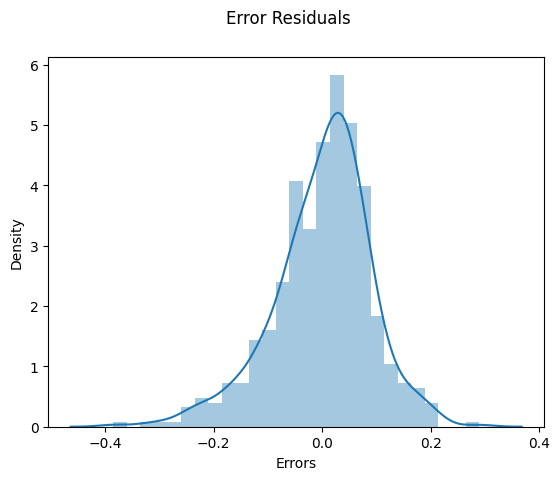

In [1127]:
sns.distplot(residual_train)
plt.suptitle('Error Residuals')
plt.xlabel('Errors')
plt.show()

R2 score of residuals: -0.0011277819198267647


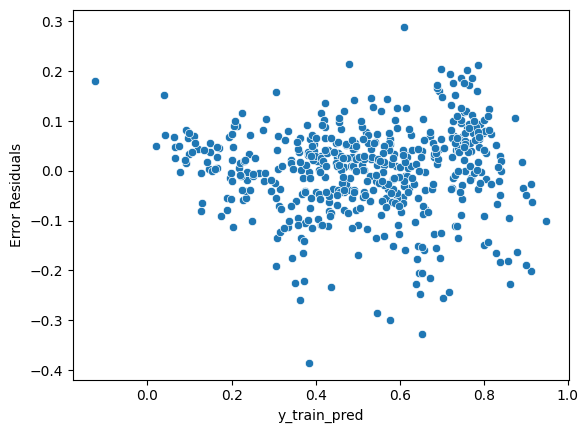

In [1128]:
print('R2 score of residuals:',residual_model.score(y_train_pred.values.reshape(-1,1), residual_train))
sns.scatterplot(x=y_train_pred, y=residual_train)
plt.xlabel('y_train_pred')
plt.ylabel('Error Residuals')
plt.show()

R2 score of residuals: -0.0011277819198267647


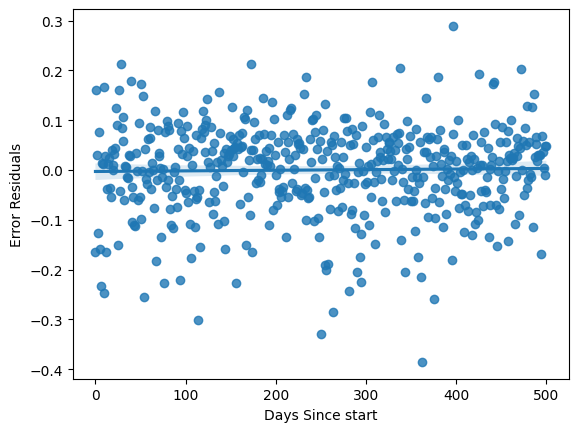

In [1129]:
residual_model = LinearRegression()
residual_model.fit(np.array(list(range(len(residual_train)))).reshape(-1,1), residual_train)
print('R2 score of residuals:',residual_model.score(y_train_pred.values.reshape(-1,1), residual_train))
sns.regplot(x=list(range(len(residual_train))), y=residual_train)
plt.xlabel('Days Since start')
plt.ylabel('Error Residuals')
plt.show()

#### we can see that the error residuals have no pattern and are thus white noise. We can thus conclude that the model obtained before is the best one and the variance that it is not able to capture is white noise
#### The residuals are very close to a normal distribution validating first assumption of Linear regression
#### The residuals dont have any trend and thus linear model is able to extract all the pattern and we dont need higher order polynomial fit.
#### The variance in the errors is also not looking like a funnel and we can assume the assumption of constant variance is also met.
#### Alos, the R2 value is very close to the R2 we got with all the features implying that this LinearRegression can capture only that much variance of the input data and rest is white noise.

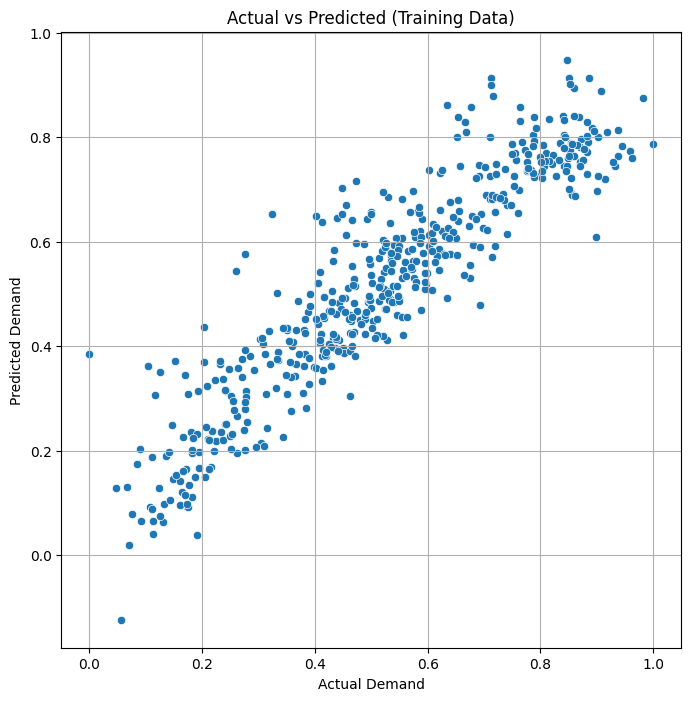

In [1130]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=y_train, y=y_train_pred)
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')
plt.title('Actual vs Predicted (Training Data)')
plt.grid()
plt.show()

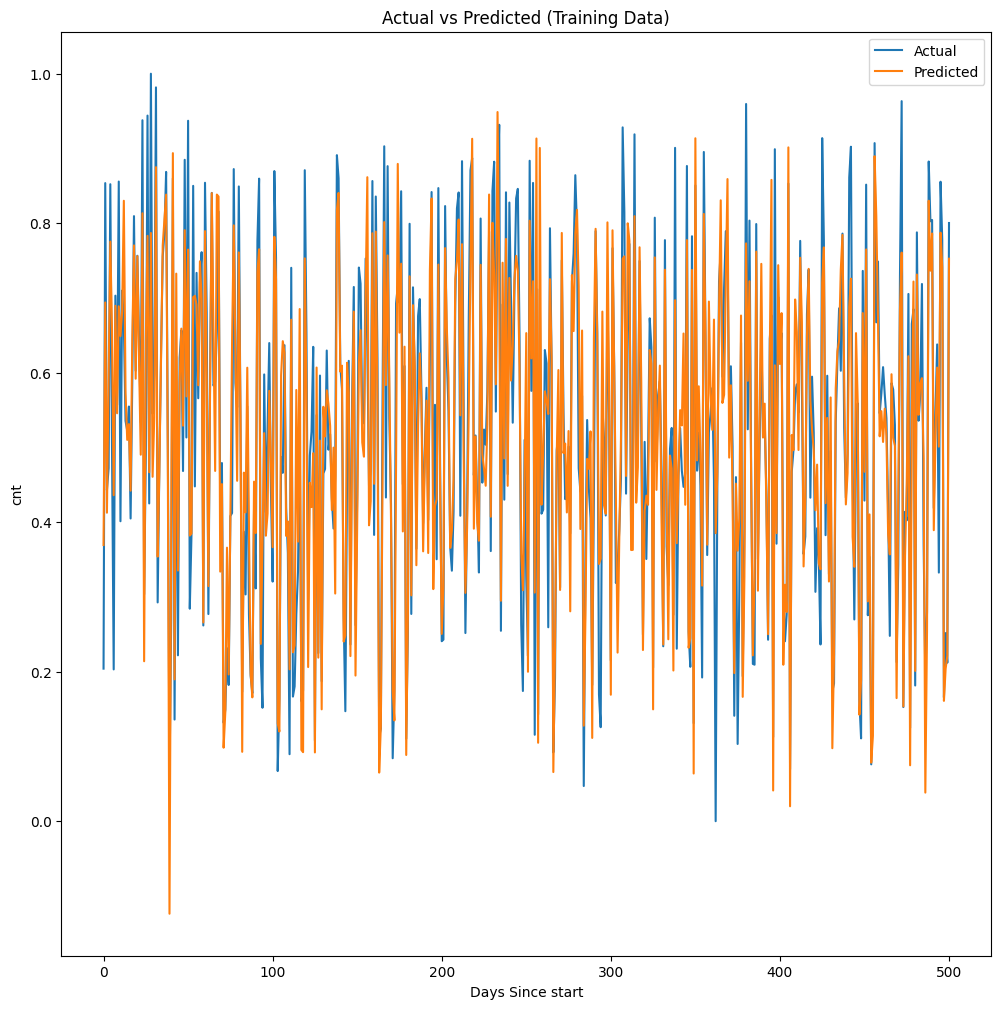

In [1131]:
# plot the train data and prediction
plt.figure(figsize=(12,12))
sns.lineplot(x=list(range(len(y_train))), y=y_train, label='Actual')
sns.lineplot(x=list(range(len(y_train_pred))), y=y_train_pred, label='Predicted')
plt.xlabel('Days Since start')
plt.ylabel('cnt')
plt.title('Actual vs Predicted (Training Data)')
plt.legend()
plt.show()

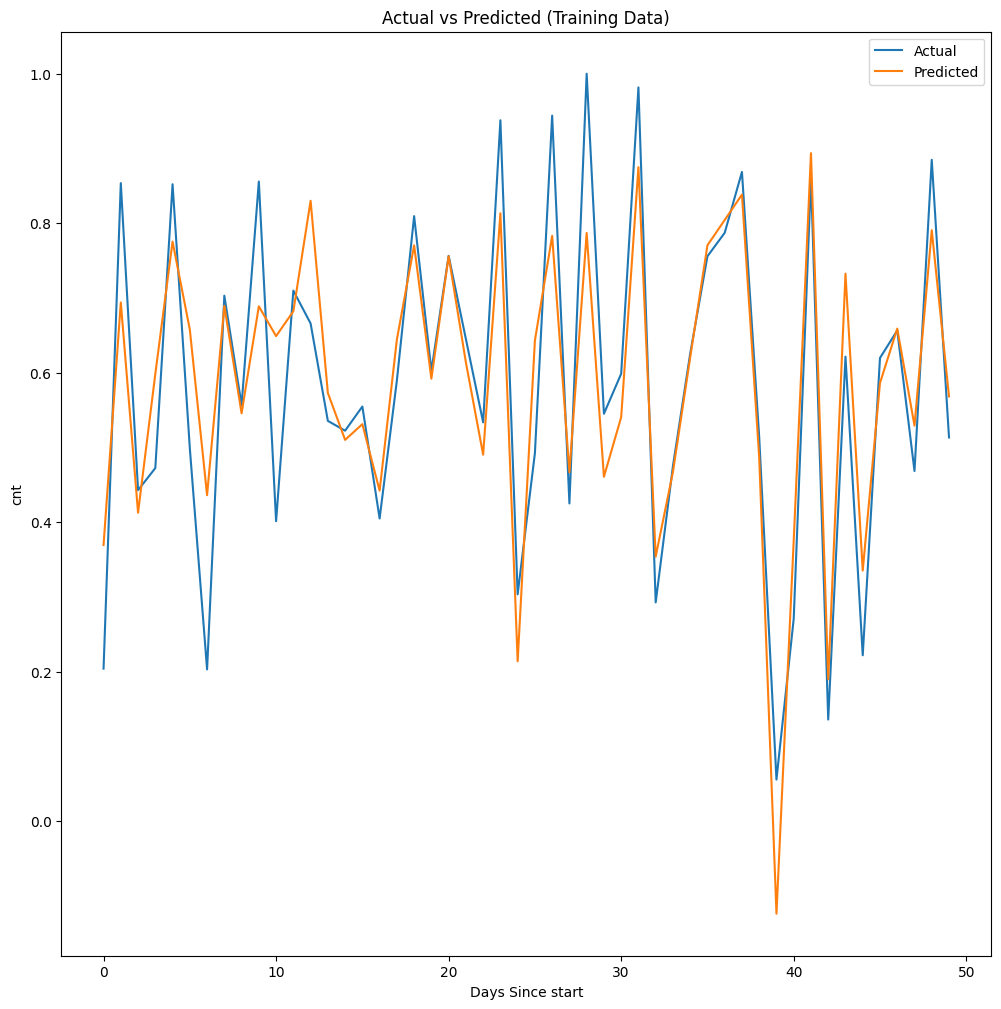

In [1132]:
# plot the train data and prediction for the first 50 days
plt.figure(figsize=(12,12))
sns.lineplot(x=list(range(len(y_train)))[:50], y=y_train[:50], label='Actual')
sns.lineplot(x=list(range(len(y_train_pred)))[:50], y=y_train_pred[:50], label='Predicted')
plt.xlabel('Days Since start')
plt.ylabel('cnt')
plt.title('Actual vs Predicted (Training Data)')
plt.legend()
plt.show()

In [1133]:
print('R2 score of train data and prediction:', r2_score(y_train, y_train_pred))
print('MSE score of train data and prediction:', mean_squared_error(y_train, y_train_pred))

R2 score of train data and prediction: 0.840060440136352
MSE score of train data and prediction: 0.008171198675686988


In [1134]:
from statsmodels.stats.stattools import durbin_watson

In [1135]:
durbin_watson(lm_model.resid)

2.07910772918099

### Most important features from the dataset

In [1136]:
lm_model.params

const           0.180193
season_2        0.078834
season_4        0.143844
yr              0.223747
holiday        -0.086901
temp            0.601675
hum            -0.202301
windspeed      -0.137630
mnth_3          0.031604
mnth_9          0.110944
weathersit_3   -0.145656
dtype: float64

In [1137]:
# print the coefficient in sorted manner based on the absolute values of coefficients
lm_model.params.drop('const', axis=0).sort_values(key=lambda x:abs(x), ascending=False)

temp            0.601675
yr              0.223747
hum            -0.202301
weathersit_3   -0.145656
season_4        0.143844
windspeed      -0.137630
mnth_9          0.110944
holiday        -0.086901
season_2        0.078834
mnth_3          0.031604
dtype: float64

#### Thus, the parameters `temp`, `yr`, `hum`, `weathersit_3`,`season_4` are the most important 5 parameters.
where,

   `weathersit_3`: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds

   `season_4`:winter

## Make predictions on the test data

In [1138]:
selected_features = list(X_train_lm.columns)
selected_features.remove('const')
bikedata_test[vars_to_scale] = scaler.transform(bikedata_test[vars_to_scale])
y_test = bikedata_test.pop('cnt')
X_test = bikedata_test

In [1139]:
X_test = X_test[selected_features]
X_test_lm = sm.add_constant(X_test)
y_test_pred = lm_model.predict(X_test_lm)
residual = y_test - y_test_pred

In [1140]:
print('R2 score on the test data:', r2_score(y_test, y_test_pred))
print('MSE score on the test data:', mean_squared_error(y_test, y_test_pred))

R2 score on the test data: 0.777093674972983
MSE score on the test data: 0.010096593437803236


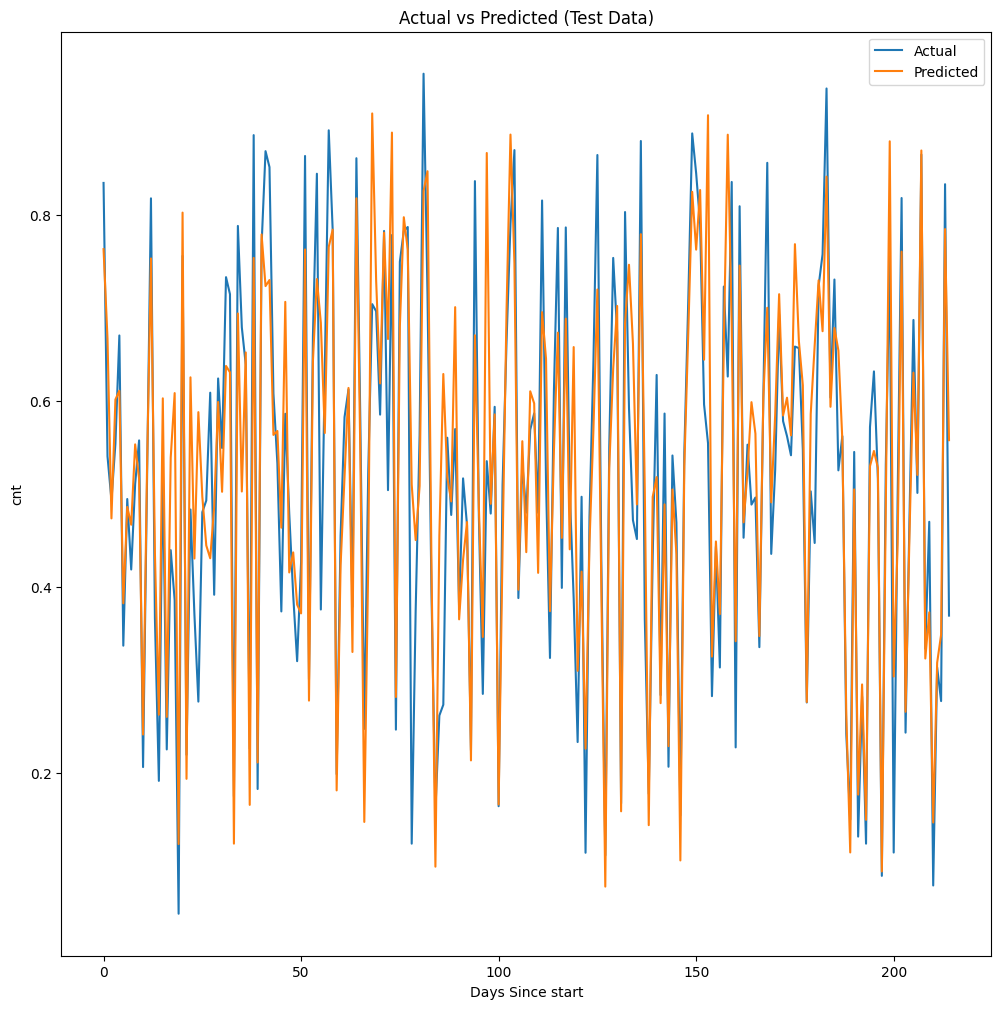

In [1141]:
# plot the test data and prediction
plt.figure(figsize=(12,12))
sns.lineplot(x=list(range(len(y_test))), y=y_test, label='Actual')
sns.lineplot(x=list(range(len(y_test_pred))), y=y_test_pred, label='Predicted')
plt.xlabel('Days Since start')
plt.ylabel('cnt')
plt.title('Actual vs Predicted (Test Data)')
plt.legend()
plt.show()

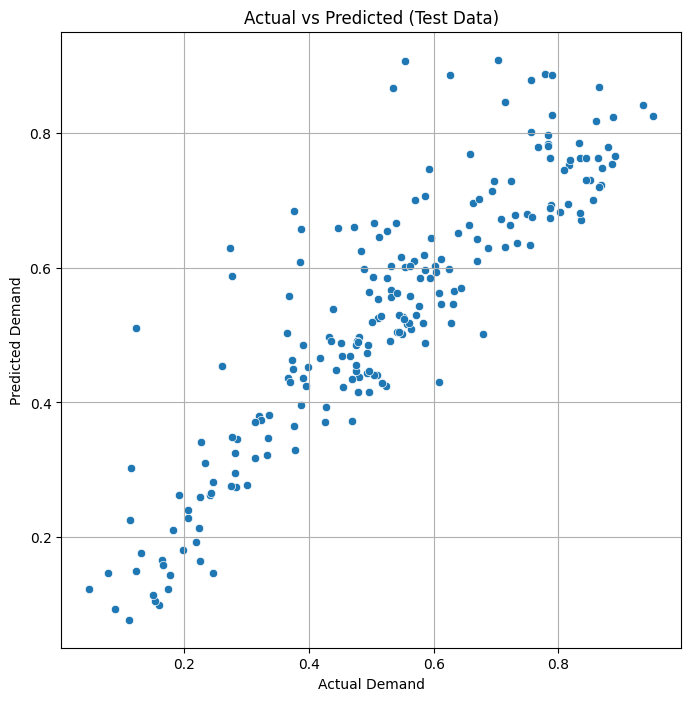

In [1142]:
plt.figure(figsize=(8,8))
sns.scatterplot(x=y_test, y=y_test_pred)
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')
plt.title('Actual vs Predicted (Test Data)')
plt.grid()
plt.show()